# Sequential Convex Programming for 6-DoF Powered Descent Guidance with Continuous-Time Compound State-Triggered Constraints

## General

<img src="sim/rocket_landing.gif" width="800" align="center">

### User input

In [1]:
save_fig = True
rl_animations = True
fig_png_dpi = 600

### Libraries

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import cvxpy as cp
import time
import copy

import jax
import jax.numpy as jnp
from jax import jit, jacfwd, vmap, lax, config, Array
config.update("jax_enable_x64", True)

import os
import glob
import warnings
import typing as T
from PIL import Image

import matplotlib as mpl
from cycler import cycler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

mpl.rcParams['figure.dpi'] = 120 
mpl.rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']}) ## for Palatino and other serif fonts use: #rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.prop_cycle'] = cycler(color=['tab:red', 'k', 'tab:green', 'tab:blue', 'tab:grey'])
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'legend.fontsize': 11})
mpl.rcParams.update({'axes.xmargin': 0})
mpl.rcParams.update({'lines.solid_capstyle': 'round'})
mpl.rcParams.update({'lines.solid_joinstyle': 'round'})
mpl.rcParams.update({'lines.dash_capstyle': 'round'})
mpl.rcParams.update({'lines.dash_joinstyle': 'round'})
mpl.rcParams.update({'text.latex.preamble': r"\usepackage{bm}"})

warnings.filterwarnings("ignore")

### D-GMSR

In [3]:
def gmsr_and(eps : float,
             p : int,
             weights : np.ndarray,
             *args : T.Tuple[T.Any]) -> T.Tuple[T.Any]:
    '''
    Input: The values of the functions and their gradients to be connected with And -> ( f, gf, g, gg, h, gh, ... )
    Output: gmsr_and function's value its gradient -> ( And(f,g,h, ...), And(gf, gg, gh) )
    '''
    
    K = len(args[0])
    fcn_vals = args[0]
    
    pos_idx = list(idx for idx, ele in enumerate(fcn_vals) if ele > 0.)
    neg_idx = list(idx for idx, ele in enumerate(fcn_vals) if ele <=  0.)
    
    pos_vals = fcn_vals[pos_idx]
    neg_vals = fcn_vals[neg_idx]
    
    pos_w = weights[pos_idx]
    neg_w = weights[neg_idx]
    
    sum_w = np.array(weights).sum()

    if neg_idx:
        # If there exits a negative element
        
        # Fcn Val
        sums = 0.
        for idx, neg_val in enumerate(neg_vals):
            sums = sums + neg_w[idx] * (neg_val**(2*p))
        
        Mp = (eps**(p) + (sums / sum_w))**(1/p)
        h_and = eps**(1/2) - Mp**(1/2)
        
        # Grad
        cp = 1/2 * Mp**(-1/2)
        cpm = 2*p / (p * sum_w * Mp**(p-1))
        
        c_i_w_i = np.zeros(K)
        c_i_w_i[neg_idx] = [ cp*cpm*(neg_w[idx] * (np.abs(neg_val))**(2*p-1)) for idx, neg_val in enumerate(neg_vals) ]
            
    else:
        # IF all are positive
        
        # Fcn Val
        mult = 1.
        for idx, pos_val in enumerate(pos_vals):
            mult = mult * ((pos_val)**(2*pos_w[idx]))

        M0 = (eps**(sum_w) + mult)**(1/sum_w)
        h_and = M0**(1/2) - eps**(1/2)
        
        # Grad
        c0 = 1/2 * M0**(-1/2)
        c0m = ( 2 * mult ) / ( sum_w * M0**(sum_w-1) )
                
        c_i_w_i = np.zeros(K)
        c_i_w_i[pos_idx] = [ c0*c0m*(pos_w[idx] / pos_val) for idx, pos_val in enumerate(pos_vals) ]
    
    return h_and, c_i_w_i

def gmsr_or(eps, p, weights, *args):
    '''
    Input: The values of the functions and their gradients to be connected with Or
    Output: gmsr_or function's value its gradient
    '''
    
    args = -args[0]
    h_mor, d_i_w_i = gmsr_and(eps, p, weights, args)
    return -h_mor, d_i_w_i

In [4]:
def UNTIL(eps : float, 
          p : int, 
          w_f : np.ndarray, 
          w_g : np.ndarray,
          w_fg : np.ndarray, 
          f : np.ndarray,
          g : np.ndarray) -> T.Tuple[T.Any]:
    
    s = []
    ds_dg = []
    ds_df = []
    
    K = f.shape[0]
    
    for i in range(K):
        y_i, dyi_dfi = gmsr_and(eps, p, w_f[0:i+1], f[0:i+1])
        s_i, dsi_dyi__dsi_dgi = gmsr_and(eps, p, w_fg[0:2], np.array([y_i, g[i]]))

        dsi_dyi = dsi_dyi__dsi_dgi[0]
        dsi_dgi = dsi_dyi__dsi_dgi[1]
        dsi_dfi = dsi_dyi * dyi_dfi

        s.append(s_i)
        ds_dg.append(dsi_dgi)
        ds_df.append(dsi_dfi)
    
    z, dz_ds = gmsr_or(eps, p, w_g, np.array(s))
    
    dz_df = np.zeros(K)
    for i, dsi_dfi in enumerate(ds_df):
        dz_df[:i+1] += dz_ds[i] * dsi_dfi
    
    dz_dg = dz_ds * np.array(ds_dg)

    return z, dz_df, dz_dg

### Gif maker

In [5]:
def make_gif(frame_folder, duration, name="animation"):

    if not os.path.exists(frame_folder):
        os.makedirs(frame_folder)

    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*"+".png"))][::2]
    print(len(frames))
    frame_one = frames[0]
    frame_one.save(frame_folder+"/" + name + ".gif", format="GIF", 
                   append_images=frames, save_all=True, duration=duration, loop=0)

### Print

In [6]:
def dict_append(dict, key, value):
    if key not in dict:
        dict[key] = []
    dict[key].append(value)

    return dict

def print_ite(log_ite_all):

    col_width = int(1 * max(len(ele) for ele in log_ite_all.keys() if ele is not None)) + 4

    if log_ite_all['Note'][-1] == 'Start':
        all_dum = ''
        for key in log_ite_all.keys():
            all_dum += key.ljust(col_width)
        print(all_dum)

    all_dum = ''
    for key in log_ite_all.keys():
        if type(log_ite_all[key]) == list:
            dum = log_ite_all[key][-1]
            if isinstance(dum, Array):
                dum = float(dum)
            if isinstance(dum, float):
                dum = round(dum, 2)
                dum = min(dum, 999999.99)

        all_dum += str(dum).ljust(col_width)
    print(all_dum)

## Successive Convexification

### Integration

In [7]:
def rk4(func : T.Any,
        y0 : np.ndarray, 
        tf : float, 
        steps : int, 
        *args : T.Tuple[T.Any]) -> np.ndarray:
    """
    Implementation of the fourth-order Runge-Kutta (RK4) method for numerical integration.

    Parameters:
    - f: Function representing the system of ordinary differential equations (ODEs).
    - y0: Initial conditions (numpy array, n-dimensional column vector).
    - t: Time points for which the solution is calculated.

    Returns:
    - y: Solution of the ODEs at each time point.
    """

    t = np.linspace(0, tf, int(steps))  # Time points

    # Ensure y0 is a NumPy array (n-dimensional column vector)
    y0 = y0.reshape(-1, 1)

    # Initialize solution array
    y = np.zeros((len(t), len(y0)))
    y[0, :] = y0.flatten()

    # Perform RK4 integration
    for i in range(len(t) - 1):

        h = t[i + 1] - t[i]
        k1 = h * func(y[i], t[i], args)
        k2 = h * func(y[i] + 0.5 * k1, t[i] + 0.5 * h, args)
        k3 = h * func(y[i] + 0.5 * k2, t[i] + 0.5 * h, args)
        k4 = h * func(y[i] + k3, t[i] + h, args)

        y[i + 1, :] = y[i, :] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return y

def dxdt(x : np.ndarray,
         t : float, 
         *args : T.Tuple[T.Any],
        ) -> np.ndarray:

    """
    return: x_dot(t)
    """

    tt, tf, u_0, u_1, params = args[0]

    if params['inp_param'] == 'FOH':
        u = u_0 + (t / tf) * (u_1 - u_0)
    elif params['inp_param'] == 'ZOH':
        u = u_0.copy()

    return params['f_func'](x, u).reshape(-1)

def integrate_dynamics(x : np.ndarray,
                       u_0 : np.ndarray,
                       u_1 : np.ndarray,
                       params : T.Dict[str, T.Any],
                       tf : float,
                       tt : float,
                      ) -> T.Tuple[np.ndarray]:
    """
    Integration of the vehicle dynamics [0, tf]
    return: x[t+dt] and u
    """
    
    x_next = rk4(dxdt, x, tf, params['rk4_steps_dyn'], tt, tf, u_0, u_1, params)[-1,:]
    return x_next

In [8]:
def rk4_jax(func, y0, tf, steps, *args):
    h = tf / (steps - 1)
    t = jnp.arange(steps) * h

    def step(y_t, t_i):
        y, _ = y_t
        k1 = h * func(y, t_i, *args)
        k2 = h * func(y + 0.5 * k1, t_i + 0.5 * h, *args)
        k3 = h * func(y + 0.5 * k2, t_i + 0.5 * h, *args)
        k4 = h * func(y + k3, t_i + h, *args)
        y_next = y + (k1 + 2*k2 + 2*k3 + k4) / 6.
        return (y_next, t_i), y_next

    (_, _), ys = lax.scan(step, (y0, t[0]), t[:-1])
    ys = jnp.vstack([y0[None, :], ys])
    return ys

def dxdt_jax(x, t, tt, tf, u_k, u_kp1, params):
    
    if params['inp_param'] == 'FOH':
        u = u_k + (t / tf) * (u_kp1 - u_k)
    elif params['inp_param'] == 'ZOH':
        u = u_k
    return params['f_func'](x, u)

def integrate_multiple(X, U, sigma, params):

    if params['free_final_time']:
        if params['time_dil']:
            sigma_vec = sigma[0]
        else:
            sigma_k = sigma / (params['K'] - 1)
            sigma_vec = jnp.ones((params['K'] - 1)) * sigma_k
    else:
        sigma_k = params['t_scp']
        sigma_vec = jnp.ones((params['K'] - 1)) * sigma_k

    tt_vec = jnp.cumsum(jnp.concatenate([jnp.zeros((1,)), sigma_vec]))[:-1]

    def body(k):
        x_k = X[:, k]
        u_k = U[:, k]
        u_kp1 = U[:, k + 1]

        sigma_k = sigma_vec[k]  # if needed
        tt = tt_vec[k]

        return rk4_jax(dxdt_jax, x_k, sigma_k, params['rk4_steps_dyn'], tt, sigma_k, u_k, u_kp1, params)[-1]
    
    x_next = vmap(body)(jnp.arange(params['K'] - 1))
    return x_next.T

### Discretization

In [9]:
def dVdt(V, t, u_0, u_1, sigma, tt, params):

    n_x = params['n_x']
    n_u = params['n_u']
    K = params['K']

    i0 = params['i0']
    i1 = params['i1']
    i2 = params['i2']
    i3 = params['i3']
    i4 = params['i4']
    i5 = params['i5']
    i6 = params['i6']

    x = V[i0:i1]

    if params['inp_param'] == 'ZOH':
        beta = 0.
    elif params['inp_param'] == 'FOH':
        beta = t / params['t_scp']
        if params['free_final_time']:
            if params['time_dil']:
                beta = t
            else:
                beta = (t / (1 / (K- 1)))

    alpha = 1 - beta
    u = u_0 + beta * (u_1 - u_0)

    A_subs = sigma * params['A_func'](x, u)
    B_subs = sigma * params['B_func'](x, u)
    f_subs = params['f_func'](x, u)

    z_t = jnp.where(
        params['free_final_time'],
        -A_subs @ x - B_subs @ u,
        f_subs - A_subs @ x - B_subs @ u
    )

    dVdt_parts = [
        sigma * f_subs.T,
        (A_subs @ V[i1:i2].reshape(n_x, n_x)).reshape(-1),
        (A_subs @ V[i2:i3].reshape(n_x, n_u) + B_subs * alpha).reshape(-1),
        (A_subs @ V[i3:i4].reshape(n_x, n_u) + B_subs * beta).reshape(-1),
        (A_subs @ V[i4:i5] + f_subs).reshape(-1),
        (A_subs @ V[i5:i6] + z_t).reshape(-1)
    ]
    return jnp.concatenate(dVdt_parts)

def calculate_discretization(X, U, sigma, params):
    
    n_x = params['n_x']
    n_u = params['n_u']
    K = params['K']

    i0 = params['i0']
    i1 = params['i1']
    i2 = params['i2']
    i3 = params['i3']
    i4 = params['i4']
    i5 = params['i5']
    i6 = params['i6']

    def single_step(k):
        x_k = X[:, k]
        u0 = U[:, k]
        u1 = U[:, k + 1]

        if params['free_final_time']:
            if params['time_dil']:
                t_scp = 1.
                tt = jnp.cumsum(jnp.concatenate((jnp.zeros(1), sigma[0, :])))
                tt_k = tt[k]
                sigma_k = sigma[0, k]
            else:
                t_scp = 1. / (K - 1)
                tt_k = k * sigma / (K - 1)
                sigma_k = sigma
        else:
            t_scp = params['t_scp']
            tt_k = k * t_scp
            sigma_k = 1.

        V0 = jnp.concatenate([
            x_k,                                 # i0:i1
            jnp.eye(n_x).reshape(-1),            # i1:i2
            jnp.zeros(i6 - i2)                   # rest: i2 onward
        ])
        
        V = rk4_jax(dVdt, V0, t_scp, params['rk4_steps_J'], u0, u1, sigma_k, tt_k, params)[-1]

        return {
            'f_bar': V[i0:i1],
            'A_bar': V[i1:i2].reshape((n_x, n_x)).flatten(order='F'),
            'B_bar': V[i2:i3].reshape((n_x, n_u)).flatten(order='F'),
            'C_bar': V[i3:i4].reshape((n_x, n_u)).flatten(order='F'),
            'S_bar': V[i4:i5],
            'z_bar': V[i5:i6],
        }

    results = jax.vmap(single_step)(jnp.arange(K - 1))

    params_z = {
        'f_bar': results['f_bar'].T,
        'A_bar': results['A_bar'].T,
        'B_bar': results['B_bar'].T,
        'C_bar': results['C_bar'].T,
        'S_bar': results['S_bar'].T,
        'z_bar': results['z_bar'].T,
    }
    
    return params_z

In [10]:
def make_calc_fn_cd(params):
    def calculate_discretization_wrapped(X, U, sigma):
        return calculate_discretization(X, U, sigma, params)
    return jit(calculate_discretization_wrapped).lower(
                    params['X_last'],
                    params['U_last'],
                    params['sigma_last']).compile()

def make_calc_fn_im(params):
    def integrate_multiple_wrapped(X, U, sigma):
        return integrate_multiple(X, U, sigma, params)
    return jit(integrate_multiple_wrapped).lower(
                    params['X_last'],
                    params['U_last'],
                    params['sigma_last']).compile()

### Linear / Nonlinear Cost

In [11]:
def scp_non_linear_cost(X_new : np.ndarray,
                        U_new : np.ndarray,
                        sigma_new : np.ndarray,
                        X_last : np.ndarray,
                        U_last : np.ndarray,
                        sigma_last : np.ndarray,
                        nu_new : np.ndarray,
                        nl_nu_new : np.ndarray,
                        w_tr : float,
                        params : T.Dict[str, T.Any],
                        cost_dict : T.Dict[str, T.Any],
                       ) -> T.Tuple[np.ndarray]:
    """
    Returns the nonlinear or linearized cost value of the SCP problem
    Required for prox-linear with adaptive step-size
    """

    dx = X_new - X_last
    du = U_new - U_last
    ds = 0.
    if params['free_final_time']:
        ds = (sigma_new - sigma_last) / params['t_f'] * params['w_ds']

        if params['time_dil']:
            cp_sum = np.linalg.norm(ds[0,:], axis=0)**2
        else:
            cp_sum = np.abs(ds)**2
    else:
        cp_sum = 0.

    ptr_cost = w_tr * ( (np.linalg.norm(dx, axis=0)**2 + np.linalg.norm(du, axis=0)**2).sum() + cp_sum.sum() )

    lcd = params['w_con_dyn'] * np.linalg.norm(nu_new.reshape(-1), 1)
    nlcd = params['w_con_dyn'] * np.linalg.norm(nl_nu_new.reshape(-1), 1)

    lin_vehicle_cost = params['vehicle_cost_fcn'](X_new, U_new, sigma_new, X_last, U_last, sigma_last, nu_new, params, npy=True)
    n_lin_vehicle_cost, cost_dict = params['vehicle_cost_fcn'](X_new, U_new, sigma_new, X_new, U_new, sigma_new, nl_nu_new, params, npy=True, cost_dict=cost_dict)

    lin_cost = lcd + lin_vehicle_cost + ptr_cost
    n_lin_cost = nlcd + n_lin_vehicle_cost

    cost_dict = dict_append(cost_dict, 'ptr_cost', ptr_cost)
    cost_dict = dict_append(cost_dict, 'lcd', lcd)
    cost_dict = dict_append(cost_dict, 'nlcd', nlcd)
    
    cost_dict = dict_append(cost_dict, 'lc', lin_cost)
    cost_dict = dict_append(cost_dict, 'nlc', n_lin_cost)

    return cost_dict

### Convex Problem (sub-problem)

In [12]:
def solve_convex_problem(X_last : np.ndarray,
                         U_last : np.ndarray,
                         sigma_last : np.ndarray,
                         w_tr : float,
                         params : T.Dict[str, T.Any],
                        ) -> T.Tuple[np.ndarray]:
       
    """
    Solves the convex sub-problem using CLARABEL or ECOS and retruns the optimal values of X, U, sigma and nu
    """

    n_x = params['n_x']
    n_u = params['n_u']

    X  = cp.Variable((n_x, params['K']))
    U  = cp.Variable((n_u, params['K']))
    nu = cp.Variable((n_x, params['K'] - 1))

    dx = X - X_last
    du = U - U_last
    if params['free_final_time']:
        if (params['time_dil']):
            sigma = cp.Variable((1, params['K'] - 1), nonneg=True)
            sig_time = sigma
            ds = (sigma - sigma_last) / params['t_f'] * params['w_ds']
            cp_sum = cp.sum(cp.norm(ds[0, :], axis=0)**2)
        else:
            sigma = cp.Variable(nonneg=True)
            sig_time = sigma * np.ones((1, params['K'] - 1))
            ds = (sigma - sigma_last) / params['t_f'] * params['w_ds']
            cp_sum = cp.sum(cp.abs(ds)**2)

        S_sigma = cp.multiply(params['S_bar'], ( np.ones( (n_x, 1) ) @ sig_time ))
    else:
        sigma = np.zeros(1)
        cp_sum = 0.
        S_sigma = np.zeros( (n_x, params['K'] - 1) )

    cost = w_tr * (cp.sum(cp.norm(dx, axis=0)**2) + cp.sum(cp.norm(du, axis=0)**2) + cp_sum) # Trust region
    cost += params['w_con_dyn'] * cp.sum(cp.abs(nu))

    constraints = [
        X[:, k + 1] ==
        cp.reshape(params['A_bar'][:, k], (n_x, n_x)) @ X[:, k]
        + cp.reshape(params['B_bar'][:, k], (n_x, n_u)) @ U[:, k]
        + cp.reshape(params['C_bar'][:, k], (n_x, n_u)) @ U[:, k+1]
        + S_sigma[:, k]
        + params['z_bar'][:, k]
        + nu[:, k]
        for k in range(params['K'] - 1)
    ]
    
    cost += params['vehicle_cost_fcn'](X, U, sigma, X_last, U_last, sigma_last, nu, params, npy=False)
    constraints += params['vehicle_cons_fcn'](X, U, sigma, X_last, U_last, sigma_last, params, npy=False)
    
    # Create the optimization problem
    problem = cp.Problem(cp.Minimize(cost), constraints)

    # Solve the optimization problem
    try:
        problem.solve(solver='MOSEK')
    except:
        problem.solve(solver='CLARABEL')

    if not(problem.status == 'optimal'): 
        print('*'*50)
        print('-'*20 + 'WARNING' + '-'*20)
        print('Problem status: ', problem.status)
        print('-'*20 + 'WARNING' + '-'*20)
        print('*'*50)
        
    if params['free_final_time']:
        sigma = sigma.value
    
    return X.value, U.value, sigma, nu.value

### Prox-linear

In [13]:
def prox_linear(params : T.Dict[str, T.Any],
               ) -> T.Dict[str, T.Any]:

    """
    Solves the non-convex trajectory optimization problem using Penalized Trust Region method (PTR)
    """
        
    X_last = params['X_last']
    U_last = params['U_last']
    sigma_last = params['sigma_last']
    w_tr = params['w_ptr']
    last_cost = None
    converged = False

    cost_dict = dict()
    ### Start with the following
    cost_dict = dict_append(cost_dict, 'Ite', 0.)
    cost_dict = dict_append(cost_dict, 'T-Ite', 0.)
    cost_dict = dict_append(cost_dict, 'T-Disc', 0.)
    cost_dict = dict_append(cost_dict, 'T-SubP', 0.)

    # Initial cost value: J(x_0, u_0, simga_0)
    X_nl_ = X_last.copy()
    X_nl_[:, 1:] = integrate_multiple_jitted(X_last, U_last, sigma_last)
    nl_nu_new_ = (X_last - X_nl_)
    cost_dict = scp_non_linear_cost(X_last, U_last, sigma_last, X_last, U_last, sigma_last, nl_nu_new_, nl_nu_new_, w_tr, params, copy.deepcopy(cost_dict))
    last_cost = cost_dict['nlc'][-1]

    cost_dict = dict_append(cost_dict, 'D-NL', 0)
    cost_dict = dict_append(cost_dict, 'D-L', 0)
    cost_dict = dict_append(cost_dict, 'Rho', 0)

    cost_dict = dict_append(cost_dict, 'W-TR', w_tr)
    cost_dict = dict_append(cost_dict, 'Note', 'Start')

    print_ite(cost_dict)
    
    for ite in range(params['ite']):
        t0_ite = time.time()
        t0_dicr = time.time()
        params_z = calculate_discretization_jitted(X_last, U_last, sigma_last)
        params.update({key: np.asarray(params_z[key]) for key in ['A_bar', 'B_bar', 'C_bar', 'S_bar', 'z_bar']})
        t_dicr = time.time() - t0_dicr

        while True:
            
            t0_cvx = time.time()
            X_new, U_new, sigma_new, nu_new = solve_convex_problem(X_last, U_last, sigma_last, w_tr, params)
            t_sub_prob = time.time() - t0_cvx

            X_nl = X_new.copy()
            X_nl[:, 1:] = integrate_multiple_jitted(X_new, U_new, sigma_new)
            nl_nu_new = (X_new - X_nl)

            cost_dict = scp_non_linear_cost(X_new, U_new, sigma_new, X_last, U_last, sigma_last, nu_new, nl_nu_new,  w_tr, params, copy.deepcopy(cost_dict))

            delta_J = last_cost - cost_dict['nlc'][-1]
            delta_L = last_cost - cost_dict['lc'][-1]
            rho = delta_J / delta_L

            if not(params['adaptive_step']):
                X_last = X_new.copy()
                U_last = U_new.copy()
                sigma_last = sigma_new.copy()

                last_cost = cost_dict['nlc'][-1]
                note = 'Constant weight'
                break

            else:

                if delta_L < -1e-6:
                    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
                    print('xxxxxxxxxxxxxxxxxxxxxxxxxx Predicted change is negative xxxxxxxxxxxxxxxxxxxxxxxxxx')
                    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
                    print('delta_L', delta_L)
                    print('w_tr', w_tr)
                    w_tr = w_tr * 2.0
                    note = '!!!'
                    break

                if delta_L < (params['ptr_term']) or (w_tr >= 1e6):
                    converged = True
                    print('delta_L', delta_L)
                    note = 'Conv'
                    break
                
                if rho <= params['r0']:
                    w_tr = w_tr * 2
                    note = 'Rjct'

                    cost_dict = dict_append(cost_dict, 'Ite', (ite + 1))
                    cost_dict = dict_append(cost_dict, 'T-Ite', time.time() - t0_ite)
                    cost_dict = dict_append(cost_dict, 'T-Disc', t_dicr)
                    cost_dict = dict_append(cost_dict, 'T-SubP', t_sub_prob)

                    cost_dict = dict_append(cost_dict, 'D-NL', delta_J)
                    cost_dict = dict_append(cost_dict, 'D-L', delta_L)
                    cost_dict = dict_append(cost_dict, 'Rho', rho)

                    cost_dict = dict_append(cost_dict, 'W-TR', w_tr)
                    cost_dict = dict_append(cost_dict, 'Note', note)

                    print_ite(cost_dict)

                else:
                    X_last = X_new.copy()
                    U_last = U_new.copy()
                    sigma_last = sigma_new.copy()
                    last_cost = cost_dict['nlc'][-1]

                    if rho < params['r1']:
                        w_tr = w_tr * 2.0
                        note = 'Decr'
                    elif params['r2'] <= rho:
                        w_tr = np.maximum(w_tr / 2.0, params['w_ptr_min'])
                        note = 'Incr'
                    else:
                        note = 'Go'
                    break

        if converged:
            print(f'Converged after {ite + 1} iterations.')
            break
        else:
            cost_dict = dict_append(cost_dict, 'Ite', (ite + 1))
            cost_dict = dict_append(cost_dict, 'T-Ite', time.time() - t0_ite)
            cost_dict = dict_append(cost_dict, 'T-Disc', t_dicr)
            cost_dict = dict_append(cost_dict, 'T-SubP', t_sub_prob)

            cost_dict = dict_append(cost_dict, 'D-NL', delta_J)
            cost_dict = dict_append(cost_dict, 'D-L', delta_L)
            cost_dict = dict_append(cost_dict, 'Rho', rho)

            cost_dict = dict_append(cost_dict, 'W-TR', w_tr)
            cost_dict = dict_append(cost_dict, 'Note', note)

            print_ite(cost_dict)

    if not converged:
        print('Maximum number of iterations reached without convergence.')
        
    cost_dict['X_new'] = X_last
    cost_dict['U_new'] = U_last
    cost_dict['sigma_new'] = sigma_last

    return cost_dict

### RUN

In [14]:
def RUN(prox_results : T.Dict[str, T.Any],
        params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    x_next = prox_results['X_new'][:,0].copy()
    x_all = [x_next]
    u_all = []

    if params['free_final_time']:
        params['t_f'] = np.sum(prox_results['sigma_new'])

    if params['time_dil']:
        sigma_k = prox_results['sigma_new'][0,:]
    else:
        sigma_k = np.ones(params['K']-1) * params['t_f'] / (params['K']-1)

    times_nodes = np.concatenate((np.zeros(1), np.cumsum(sigma_k)))

    times_all = []
    for idx in range(params['K'] - 1):

        N_dt_k = int(np.ceil(sigma_k[idx] / (params['t_scp'] / params['N_dt'])))
        delta_sigma = sigma_k[idx] / N_dt_k
        for t_in in np.linspace(0, sigma_k[idx]-(delta_sigma), N_dt_k):
            params['t_curr'] = times_nodes[idx] + t_in
            times_all.append(params['t_curr'])

            if params['inp_param'] == 'ZOH':
                u_0 = prox_results['U_new'][:, idx]
                u_1 = prox_results['U_new'][:, idx]
                
            elif params['inp_param'] == 'FOH':
                beta_1 = t_in / sigma_k[idx]
                beta_2 = (t_in+delta_sigma) / sigma_k[idx]

                u_0 = prox_results['U_new'][:, idx] + beta_1 * (prox_results['U_new'][:, idx+1] - prox_results['U_new'][:, idx])
                u_1 = prox_results['U_new'][:, idx] + beta_2 * (prox_results['U_new'][:, idx+1] - prox_results['U_new'][:, idx])
            
            x_next = integrate_dynamics(x_next, u_0, u_1, params, delta_sigma, tt=params['t_curr'])

            x_all.append(x_next)
            u_all.append(np.vstack((u_0, u_1)))

    times_all.append(times_nodes[-1])
    times_all = np.array(times_all)

    scp_results = dict()
    scp_results['times_all'] = times_all
    scp_results['times_nodes'] = times_nodes

    scp_results['x_all'] = np.vstack(x_all)
    scp_results['u_all'] = np.dstack(u_all)
    scp_results['x_nmpc_all'] = np.dstack(prox_results['X_new'])
    scp_results['u_nmpc_all'] = np.dstack(prox_results['U_new'])
    scp_results['sigma_nmpc_all'] = prox_results['sigma_new']

    return scp_results

## Rocket Landing

### Utils

In [15]:
def euler_to_quat(a):
    a = np.deg2rad(a)

    cy = np.cos(a[1] * 0.5)
    sy = np.sin(a[1] * 0.5)
    cr = np.cos(a[0] * 0.5)
    sr = np.sin(a[0] * 0.5)
    cp = np.cos(a[2] * 0.5)
    sp = np.sin(a[2] * 0.5)

    q = np.zeros(4)

    q[0] = cy * cr * cp + sy * sr * sp
    q[1] = cy * sr * cp - sy * cr * sp
    q[3] = cy * cr * sp + sy * sr * cp
    q[2] = sy * cr * cp - cy * sr * sp

    return q

def CBI_fcn(q):
    a1 = [1 - 2 * (q[2] ** 2 + q[3] ** 2), 2 * (q[1] * q[2] + q[0] * q[3]), 2 * (q[1] * q[3] - q[0] * q[2])]
    a2 = [2 * (q[1] * q[2] - q[0] * q[3]), 1 - 2 * (q[1] ** 2 + q[3] ** 2), 2 * (q[2] * q[3] + q[0] * q[1])]
    a3 = [2 * (q[1] * q[3] + q[0] * q[2]), 2 * (q[2] * q[3] - q[0] * q[1]), 1 - 2 * (q[1] ** 2 + q[2] ** 2)]
    return jnp.array([a1,a2,a3])

def skew(v):
    return jnp.array([
                        [0, -v[2], v[1]],
                        [v[2], 0, -v[0]],
                        [-v[1], v[0], 0]
                    ])
def omega(w):
    return jnp.array([
                        [0,    -w[0], -w[1], -w[2]],
                        [w[0],     0,  w[2], -w[1]],
                        [w[1], -w[2],     0,  w[0]],
                        [w[2],  w[1], -w[0],     0],
                    ])

def rotation_matrix(angle):
    phi, theta, psi = angle
    R_roll = jnp.array([[1, 0, 0],
                        [0, jnp.cos(phi), -jnp.sin(phi)],
                        [0, jnp.sin(phi), jnp.cos(phi)]
                        ])
    
    R_pitch = jnp.array([[jnp.cos(theta), 0, jnp.sin(theta)],
                         [0, 1, 0],
                         [-jnp.sin(theta), 0, jnp.cos(theta)]
                         ])
    
    R_yaw = jnp.array([[jnp.cos(psi), -jnp.sin(psi), 0],
                       [jnp.sin(psi), jnp.cos(psi), 0],
                       [0, 0, 1]
                       ])
    
    return jnp.dot(R_yaw, jnp.dot(R_pitch, R_roll))

### Parameters

In [16]:
def rl_params_fcn() -> T.Dict[str, T.Any]:

    """
    Static parameters for the scenario
    """

    t_f = 21
    K = 15
    t_scp = t_f / (K-1)
    N_dt = 10

    n_x = 15
    n_u = 5

    g_0 = 9.806 # Earth's gravity at sea-level [m/s^2] 
    I_sp = 330. # Rocket engine specific impulse [s]

    # Mass
    m_wet = 100000. # kg
    m_dry = 85000. # kg

    r_I_init = np.array([200., 200., 500.])  # 2000 m, 200 m, 200 m
    v_I_init = np.array([0., 0., -50.])  # -300 m/s, 50 m/s, 50 m/s
    q_B_I_init = euler_to_quat(np.array([90., 0., 0.]))
    w_B_init = np.deg2rad((0., 0., 0.))

    r_I_final = np.array([0., 0., 0.])
    v_I_final = np.array([0., 0., -5.])
    q_B_I_final = euler_to_quat(np.array([0., 0., 0.]))
    w_B_final = np.deg2rad((0., 0., 0.))

    # Boundary conditions
    # 'm rx ry rz vx vy vz q0 q1 q2 q3 wx wy wz'
    x_init = np.concatenate(((m_wet,), r_I_init, v_I_init, q_B_I_init, w_B_init, np.zeros(1)))
    x_final = np.concatenate(((m_dry,), r_I_final, v_I_final, q_B_I_final, w_B_final, np.zeros(1)))

    return dict(
        # ---------------------------------------------------------------------------------------------------
        w_stc_1 = 100,
        w_stc_2 = 1000,
        w_stc_3 = 600,

        theta_max = 90,
        gs_max = 90 - 35,

        delta_engine_max = 10,
        delta_boresight_max = 20,

        alt_stc_trig = 100,
        alt_stc_trig_los = 200,
        alt_stc_trig_los_gs_done = 2.0,

        spd_stc_trig = 35.0,
        theta_stc_trig = 60,

        spd_stc_cons = 20.0,
        omega_stc_cons = 2.5,
        theta_stc_cons = 5.0,
        gs_stc_cons = 90 - 5,
        delta_stc_cons = 1.0,
        los_stc_cons = 5,

        rho_air = 1.225, # Air density [kg m^{-3}]
        S_area = 545, # Area of the rocket [m^{2}]
        C_aero = np.array([[0.4068, 0.,     0.],
                           [0.,     0.4068, 0.],
                           [0.,     0.,     0.0522]]), # Drag coefficient

        l_r = 4.5, # Radius of the fusulage [m]
        l_h = 50., # Height of the fusulage [m]

        # Vector from thrust point to Center of Mass
        r_cm = np.array([0., 0., -14.]), # The distance between the CM and the engine [m] 
        r_cp = np.array([0., 0., 3.]), # The distance between the CP and the engine [m] 

        # General Parameters
        t_f = t_f,
        K = K,
        t_scp = t_scp,
        N_dt = N_dt,
        free_final_time = True,
        time_dil = True,

        n_x = n_x,
        n_u = n_u,
        i0 = 0,
        i1 = n_x,
        i2 = (n_x) + n_x * n_x,
        i3 = ((n_x) + n_x * n_x) + n_x * n_u,
        i4 = (((n_x) + n_x * n_x) + n_x * n_u) + n_x * n_u,
        i5 = ((((n_x) + n_x * n_x) + n_x * n_u) + n_x * n_u) + n_x,
        i6 = (((((n_x) + n_x * n_x) + n_x * n_u) + n_x * n_u) + n_x) + n_x,
        inp_param = 'FOH',

        x_init  = x_init,
        x_final = x_final,

        m_wet = m_wet,
        m_dry = m_dry,

        w_sigma = 150,
        add_minmax_sig = True,
        min_sigma = t_scp * 0.5,
        max_sigma = t_scp * 10.,
        
        # Rocket Landing
        w_B_max = np.deg2rad(90),

        # Thrust limits
        T_max = 2200000. * 3.0, # [kg*m/s^2]
        T_min = 2200000 * 0.4 * 3.0, # [kg*m/s^2]
        T_max_aft = 2200000., # [kg*m/s^2]
        T_min_aft = 2200000 * 0.4, # [kg*m/s^2]

        # Angular moment of inertia
        J_B = np.diag([60., 60., 1.5]),
        J_B_inv = np.diag([1/60., 1/60., 1/1.5]),

        # Gravity
        g_I = np.array((0., 0., -g_0)), # [m/s^2]

        # Fuel consumption
        alpha_m = 1 / (I_sp * g_0),  # [s/m]

        # ---------------------------------------------------------------------------------------------------

        # Prox-linear Parameters
        ite = 85, # Total number of iterations for the prox-linear algorithm
        w_con_dyn = 1e4, # Penalization weight for the constraints
        
        # Prox-linear via adaptive step-size
        adaptive_step = False, # Updates the penalization cost of prox-linear
        ptr_term = 1e-4, # Termination condition
        w_ds = 20, # Extra penaliztion for time
        w_ptr = 2**(12), # Initial penaliztion weight for the trust-regrion
        w_ptr_min = 0.001, # Minimum penaliztion weight for the trust-regrion
        r0 = 0.01, # Minimum linearization accuracy to accept the SCP iteration and increase w_ptr
        r1 = 0.1, # Minimum linearization accuracy to use the same w_ptr
        r2 = 0.8, # Minimum linearization accuracy to decrease the w_ptr

        # ---------------------------------------------------------------------------------------------------

        # CTCS
        beta_ctcs = 1e-4,

        alpha_alt_stc_trig = 1.1,
        alpha_alt_alt_stc_trig_los = 1.1,
        alpha_T_min = 1.02,

        alpha_spd_stc_cons = 0.95,
        alpha_omega_stc_cons = 0.99,
        alpha_theta_stc_cons = 0.92,
        alpha_gs_stc_cons = 0.92,
        alpha_los_stc_cons = 0.98,

        # Integration
        rk4_steps_dyn = 20,
        rk4_steps_J = 20,

        # Scale params
        r_scale = np.linalg.norm(r_I_init),
        m_scale = m_wet,

        # ---------------------------------------------------------------------------------------------------
    )

### Initialization

In [17]:
def initialize_trajectory(params):
    """
    Initialize the trajectory.
    """

    # Initialization
    X_last = np.linspace(params['x_init'], params['x_final'], params['K']).T
    U_last = np.zeros((params['n_u'], params['K']))
    U_last[0, :] = (params['T_max'] + params['T_min']) / 2
    
    if params['time_dil']:
        sigma_last = params['t_scp'] * np.ones((1, params['K'] - 1))
    else:
        sigma_last = params['t_f']

    params['X_last'] = X_last
    params['U_last'] = U_last
    params['sigma_last'] = sigma_last

    return params

### Scaling

In [18]:
def rl_scale_params(params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    r_scale = params['r_scale']
    m_scale = params['m_scale']

    params['alpha_m'] = params['alpha_m'] * r_scale  # s
    params['r_cm'] = params['r_cm'] / r_scale  # 1
    params['r_cp'] = params['r_cp'] / r_scale  # 1
    params['g_I'] = params['g_I'] / r_scale  # 1/s^2
    params['J_B'] = params['J_B'] / (r_scale ** 2)  # 1
    params['J_B_inv'] = params['J_B_inv'] * (r_scale ** 2)  # 1

    params['rho_air'] = params['rho_air'] / (r_scale*m_scale) * (r_scale*r_scale)
    
    params['m_wet'] = params['m_wet'] / m_scale
    params['m_dry'] = params['m_dry'] / m_scale

    params['x_init'][0] = params['x_init'][0] / m_scale
    params['x_init'][1:4] = params['x_init'][1:4] / r_scale
    params['x_init'][4:7] = params['x_init'][4:7] / r_scale

    params['x_final'][0] = params['x_final'][0] / m_scale
    params['x_final'][1:4] = params['x_final'][1:4] / r_scale
    params['x_final'][4:7] = params['x_final'][4:7] / r_scale

    params['X_last'][0] = params['X_last'][0] / m_scale
    params['X_last'][1:4] = params['X_last'][1:4] / r_scale
    params['X_last'][4:7] = params['X_last'][4:7] / r_scale
    
    params['T_max'] = params['T_max'] / (m_scale * r_scale)
    params['T_min'] = params['T_min'] / (m_scale * r_scale)
    params['T_max_aft'] = params['T_max_aft'] / (m_scale * r_scale)
    params['T_min_aft'] = params['T_min_aft'] / (m_scale * r_scale)

    params['U_last'][0, :] = params['U_last'][0, :] / (m_scale * r_scale)

    params['alt_stc_trig'] = params['alt_stc_trig'] / r_scale
    params['alt_stc_trig_los'] = params['alt_stc_trig_los'] / r_scale
    params['alt_stc_trig_los_gs_done'] = params['alt_stc_trig_los_gs_done'] / r_scale
    params['spd_stc_cons'] = params['spd_stc_cons'] / r_scale
    params['spd_stc_trig'] = params['spd_stc_trig'] / r_scale

    return params

def rl_unscale_results(results : T.Dict[str, T.Any], params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    r_scale = params['r_scale']
    m_scale = params['m_scale']

    results['x_all'][:, 0] = results['x_all'][:, 0] * m_scale
    results['x_all'][:, 1:4] = results['x_all'][:, 1:4] * r_scale
    results['x_all'][:, 4:7] = results['x_all'][:, 4:7] * r_scale

    results['u_all'][:, 0, :] = results['u_all'][:, 0, :] * (m_scale * r_scale)

    results['x_nmpc_all'][0, :, 0] = results['x_nmpc_all'][0, :, 0] * m_scale
    results['x_nmpc_all'][0, :, 1:4] = results['x_nmpc_all'][0, :, 1:4] * r_scale
    results['x_nmpc_all'][0, :, 4:7] = results['x_nmpc_all'][0, :, 4:7] * r_scale

    results['u_nmpc_all'][0, :, 0] = results['u_nmpc_all'][0, :, 0] * (m_scale * r_scale)

    return results

### Vehcile Dynamics

In [19]:
def rl_dynamics(params: T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    g_I = jnp.array(params['g_I'])
    r_cm = jnp.array(params['r_cm'])
    r_cp = jnp.array(params['r_cp'])
    J_B_inv_pre = jnp.array(params['J_B_inv'])
    J_B_pre = jnp.array(params['J_B'])

    def dynamics(x, u):

        CBI = CBI_fcn(x[7:11])
        CIB = CBI.transpose()

        f = jnp.zeros(params['n_x'])

        J_B_inv_m = J_B_inv_pre / x[0]
        J_B_m = J_B_pre * x[0]

        f = f.at[0].set(- params['alpha_m'] * u[0])

        f = f.at[1:4].set(x[4:7])

        v_norm = (x[4]**2 + x[5]**2 + x[6]**2 + 1e-8)**(0.5)
        A_B = - 0.5 * params['rho_air'] * v_norm * params['S_area'] * (params['C_aero'] @ (CBI @ x[4:7]))

        T_v = jnp.array( [u[0] * jnp.sin(u[1]) * jnp.cos(u[2]), 
                            u[0] * jnp.sin(u[1]) * jnp.sin(u[2]), 
                            u[0] * jnp.cos(u[1])] )
        
        f = f.at[4:7].set( ((1 / x[0]) * (jnp.dot(CIB, (T_v + A_B) ))) + g_I )

        ox = omega(x[11:14])
        f = f.at[7].set( 1 / 2 * (ox[0,0]*x[7] + ox[0,1]*x[8] + ox[0,2]*x[9] + ox[0,3]*x[10]))
        f = f.at[8].set( 1 / 2 * (ox[1,0]*x[7] + ox[1,1]*x[8] + ox[1,2]*x[9] + ox[1,3]*x[10]))
        f = f.at[9].set( 1 / 2 * (ox[2,0]*x[7] + ox[2,1]*x[8] + ox[2,2]*x[9] + ox[2,3]*x[10]))
        f = f.at[10].set(1 / 2 * (ox[3,0]*x[7] + ox[3,1]*x[8] + ox[3,2]*x[9] + ox[3,3]*x[10]))
        f = f.at[11:14].set(jnp.dot(J_B_inv_m, jnp.dot(skew(r_cm), T_v[0:3]) + jnp.dot(skew(r_cp), A_B) - jnp.dot(skew(x[11:14]), (J_B_m @ x[11:14]))))

        # ------------------------------------------------

        tilt_ang_cons_pre = params['w_stc_1'] * ((x[8]**2 + x[9]**2 + 1e-8)**(0.5) - np.sqrt((1 - np.cos(np.deg2rad(params['theta_max']))) / 2))
        tilt_ang_cons = (jnp.maximum(0., tilt_ang_cons_pre)**2)

        ang_vel_cons_pre = params['w_stc_1'] * ((x[11]**2 + x[12]**2 + x[13]**2 + 1e-8)**(0.5) - params['w_B_max'])
        ang_vel_cons  = (jnp.maximum(0.,  ang_vel_cons_pre  )**2)

        gs_cons_pre = np.tan(np.deg2rad(params['gs_max'])) * (x[1]**2 + x[2]**2 + 1e-8)**(0.5) - x[3]
        gs_cons = params['w_stc_1'] * (jnp.maximum(0., gs_cons_pre)**2)

        # ------------------------------------------------

        alt_stc_trig_i = params['w_stc_1'] * (jnp.maximum(0., params['alt_stc_trig'] - x[3])**2)
        alt_stc_trig_i_alpha = params['w_stc_1'] * (jnp.maximum(0., params['alpha_alt_stc_trig'] * params['alt_stc_trig'] - x[3])**2)
        alt_stc_trig_f = params['w_stc_1'] * (jnp.maximum(0., x[3] - params['alt_stc_trig_los_gs_done'])**2)
        alt_stc_trig_los = params['w_stc_1'] * (jnp.maximum(0., params['alpha_alt_alt_stc_trig_los'] * params['alt_stc_trig_los'] - x[3])**2)

        spd_stc_trig_i = params['w_stc_2'] * (jnp.maximum(0., (x[4]**2 +  x[5]**2 +  x[6]**2 + 1e-8)**(0.5) - params['spd_stc_trig'] )**2)
        spd_stc_trig_f = params['w_stc_2'] * (jnp.maximum(0., params['spd_stc_trig'] - (x[4]**2 +  x[5]**2 +  x[6]**2 + 1e-8)**(0.5) )**2)

        theta_stc_trig_i = params['w_stc_2'] * jnp.maximum(0.,  (x[8]**2 + x[9]**2 + 1e-8)**(0.5) - np.sqrt((1 - np.cos(np.deg2rad(params['theta_stc_trig']))) / 2))**2
        theta_stc_trig_f = params['w_stc_2'] * jnp.maximum(0., -(x[8]**2 + x[9]**2 + 1e-8)**(0.5) + np.sqrt((1 - np.cos(np.deg2rad(params['theta_stc_trig']))) / 2))**2

        # ------------------------------------------------

        gimbal_ang_stc_cons_pre_1 = u[1] - params['delta_stc_cons'] * np.pi/180
        gimbal_ang_stc_cons_pre_2 = - u[1] - params['delta_stc_cons'] * np.pi/180
        gimbal_ang_stc_cons_1 = params['w_stc_1'] * jnp.maximum(0, gimbal_ang_stc_cons_pre_1)**2
        gimbal_ang_stc_cons_2 = params['w_stc_1'] * jnp.maximum(0, gimbal_ang_stc_cons_pre_2)**2
        gimbal_ang_stc_cons = gimbal_ang_stc_cons_1 + gimbal_ang_stc_cons_2

        gs_stc_cons_pre =  np.tan(np.deg2rad(params['alpha_gs_stc_cons'] * params['gs_stc_cons'])) * (x[1]**2 + x[2]**2 + 1e-8)**(0.5) - x[3]
        gs_stc_cons = params['w_stc_1'] * jnp.maximum(0, gs_stc_cons_pre)**2

        omega_stc_cons_pre = (x[11]**2 + x[12]**2 + x[13]**2 + 1e-8)**(0.5) - np.deg2rad(params['omega_stc_cons']) * params['alpha_omega_stc_cons']
        omega_stc_cons = params['w_stc_1'] * (jnp.maximum(0., omega_stc_cons_pre)**2)
        
        tilt_ang_stc_cons_pre = (x[8]**2 + x[9]**2 + 1e-8)**(0.5) - np.sqrt((1 - np.cos(np.deg2rad(params['alpha_theta_stc_cons'] * params['theta_stc_cons']))) / 2)
        tilt_ang_stc_cons = params['w_stc_2'] * jnp.maximum(0., tilt_ang_stc_cons_pre)**2

        los_I = - jnp.dot( CIB, jnp.array([jnp.sin(u[3]) * jnp.cos(u[4]), 
                                           jnp.sin(u[3]) * jnp.sin(u[4]), 
                                           jnp.cos(u[3])] ) 
                                           )

        los_I_norm = (los_I[0]**2 + los_I[1]**2 + los_I[2]**2 + 1e-8)**(0.5)
        los_pos_norm = (x[1]**2 + x[2]**2 + x[3]**2 + 1e-8)**(0.5)

        los_stc_cons_pre = los_pos_norm * los_I_norm * np.cos(params['alpha_los_stc_cons'] * params['los_stc_cons']*np.pi/180) - jnp.dot( -x[1:4], los_I )
        los_stc_cons = params['w_stc_3'] * jnp.maximum(0., los_stc_cons_pre )**2

        spd_stc_cons_pre = (x[4]**2 +  x[5]**2 +  x[6]**2 + 1e-8)**(0.5) - params['alpha_spd_stc_cons'] * params['spd_stc_cons']
        spd_stc_cons = params['w_stc_3'] * (jnp.maximum(0., spd_stc_cons_pre)**2)

        thrust_min_f = params['w_stc_3'] * (jnp.maximum(0, params['T_min_aft'] - u[0] )**2)
        thrust_max_f = params['w_stc_3'] * (jnp.maximum(0, u[0] - params['T_max_aft'] )**2)

        thrust_min_i = params['w_stc_3'] * (jnp.maximum(0, params['alpha_T_min'] * params['T_min'] - u[0] )**2)
        thrust_max_i = params['w_stc_3'] * (jnp.maximum(0, u[0] - params['T_max'] )**2)
        
        gimbal_ang_stc = alt_stc_trig_i * gimbal_ang_stc_cons
        gs_stc = alt_stc_trig_i * alt_stc_trig_f * gs_stc_cons
        tilt_ang_stc = alt_stc_trig_i * tilt_ang_stc_cons
        los_stc = alt_stc_trig_los * alt_stc_trig_f * los_stc_cons
        spds_stcs = alt_stc_trig_i_alpha * (omega_stc_cons + spd_stc_cons)
        thrust_stc_f = (spd_stc_trig_f * theta_stc_trig_f) * (thrust_max_f + thrust_min_f)
        thrust_stc_i = (spd_stc_trig_i + theta_stc_trig_i) * (thrust_max_i + thrust_min_i)

        # ------------------------------------------------

        f = f.at[14].set(tilt_ang_cons + ang_vel_cons + gs_cons + gs_stc + los_stc + tilt_ang_stc + spds_stcs + gimbal_ang_stc + thrust_stc_f + thrust_stc_i)
        
        return f

    # Define JAX functions for Jacobians
    params['f_func'] = jit(dynamics)
    params['A_func'] = jit(jacfwd(dynamics, argnums=0))
    params['B_func'] = jit(jacfwd(dynamics, argnums=1))

    return params

### Vehicle Constraints

In [20]:
def rl_cost_fcn(X : np.ndarray,
                U : np.ndarray,
                sigma : np.ndarray,
                X_last : np.ndarray,
                U_last : np.ndarray,
                sigma_last : np.ndarray,
                nu : np.ndarray,
                params : T.Dict[str, T.Any],
                npy : bool,
                cost_dict : T.Dict[str, T.Any] = None,
                ) -> T.Tuple[T.Any]:
    # --------------------------------------------------------------------------------------------------------------
    
    vehicle_cost = 0.
    if cost_dict is not None: 
        n_lin_vehicle_cost = 0.

    if params['free_final_time']:
        if params['time_dil']:
            if npy:
                sigma_cost = params['w_sigma'] * np.linalg.norm(sigma[0, :], 1) / params['t_f']
            else:
                sigma_cost = params['w_sigma'] * cp.pnorm(sigma[0, :], 1) / params['t_f']
        else:
            if npy:
                sigma_cost = params['w_sigma'] * sigma / params['t_f']
            else:
                sigma_cost = params['w_sigma'] * cp.pnorm(sigma, 1) / params['t_f']

        vehicle_cost += sigma_cost

        if cost_dict is not None:
            cost_dict = dict_append(cost_dict, 'sigma_cost', sigma_cost)
            n_lin_vehicle_cost += sigma_cost

    # --------------------------------------------------------------------------------------------------------------

    if cost_dict is not None:
        dyn_cost = params['w_con_dyn'] * np.linalg.norm(nu.reshape(-1), 1)
        cost_dict = dict_append(cost_dict, 'dyn_cost', dyn_cost)

    # --------------------------------------------------------------------------------------------------------------

    if cost_dict is not None:
        return n_lin_vehicle_cost, cost_dict
    else:
        return vehicle_cost

def rl_cons_fcn(X : np.ndarray,
                 U : np.ndarray,
                 sigma : np.ndarray,
                 X_last : np.ndarray,
                 U_last : np.ndarray,
                 sigma_last : np.ndarray,
                 params : T.Dict[str, T.Any],
                 npy : bool,
                 ) -> T.Tuple[T.Any]:
    
    vehicle_cons = []

    # --------------------------------------------------------------------------------------------------------------

    if params['free_final_time']:
        if params['time_dil']:
            if params['add_minmax_sig']:
                vehicle_cons += [
                        sigma[0, :] >= params['min_sigma'],
                        sigma[0, :] <= params['max_sigma'],
                    ]
                
    # --------------------------------------------------------------------------------------------------------------

    # Boundary conditions
    vehicle_cons += [X[:, 0] == params['x_init']]
    vehicle_cons += [X[1:-1, -1] == params['x_final'][1:-1]]

    # Continuous-time Constraint Satisfaction
    vehicle_cons += [X[-1:, 1:] - X[-1:, 0:-1] <= params['beta_ctcs']]

    # State constraints:
    vehicle_cons += [X[0, :] >= params['m_dry']] # minimum mass

    # Control constraints:
    vehicle_cons += [
        U[0, :] <= params['T_max'],
        params['T_min_aft'] <= U[0, :],
        -params['delta_engine_max'] * np.pi/180 <= U[1, :],
        U[1, :] <= params['delta_engine_max'] * np.pi/180,
        U[3, :] <= params['delta_boresight_max'] * np.pi/180,
        -params['delta_boresight_max'] * np.pi/180 <= U[3, :],
    ]

    # --------------------------------------------------------------------------------------------------------------
    
    return vehicle_cons

### Plot

In [21]:
def plot_3d_rocket(ax, center, direction, radius, length):
    # Normalize the direction vector
    direction = np.array(direction)
    direction = direction / np.linalg.norm(direction)
    
    # Generate a perpendicular vector to the rocket direction
    if np.allclose(direction, [0, 0, 1]):
        perp_vector = np.array([1, 0, 0])
    else:
        perp_vector = np.cross(direction, [0, 0, 1])
        perp_vector = perp_vector / np.linalg.norm(perp_vector)
    
    # Generate another vector perpendicular to both direction and perp_vector
    perp_vector_2 = np.cross(direction, perp_vector)
    
    # Generate points for the cylinder
    num_points = 50
    theta = np.linspace(0, 2 * np.pi, num_points)
    circle = np.array([radius * np.cos(theta), radius * np.sin(theta), np.zeros(num_points)])
    
    # Create two ends of the cylinder
    base_circle = center[:, np.newaxis] + circle[0] * perp_vector[:, np.newaxis] + circle[1] * perp_vector_2[:, np.newaxis]
    top_center = center + length * direction
    top_circle = top_center[:, np.newaxis] + circle[0] * perp_vector[:, np.newaxis] + circle[1] * perp_vector_2[:, np.newaxis]

    # Plotting the cylinder
    for i in range(num_points - 1):
        verts = [ [base_circle[:, i], base_circle[:, i+1], 
                   top_circle[:, i+1], top_circle[:, i]] ]
        ax.add_collection3d(Poly3DCollection(verts, color='dimgray', 
                                             linewidths=1, edgecolors='black', alpha=0.8, zorder=20))
    
    # Plotting the cone (rocket nose)
    cone_tip = top_center + direction * (length / 4)  # Adjust cone length as needed
    for i in range(num_points - 1):
        verts = [ [top_circle[:, i], top_circle[:, i+1], cone_tip] ]
        ax.add_collection3d(Poly3DCollection(verts, color='grey', linewidths=1, 
                                             edgecolors='black', alpha=0.8, zorder=20))

In [22]:
def plot_cone(ax, center, direction, angle, height=5, num_points=50, cc='purple', label=None, lw=0.5, zorder=None, cone_label=False):

    if not(zorder): zorder=15

    direction = np.array(direction)
    direction = direction / np.linalg.norm(direction)  # Normalize the direction vector

    # Set up the grid in polar coordinates
    theta = np.linspace(0, 2 * np.pi, num_points)
    r = np.linspace(0, height * np.tan(np.radians(angle)), num_points)
    T, R = np.meshgrid(theta, r)

    # Calculate X, Y, Z in the base orientation
    X = R * np.cos(T)
    Y = R * np.sin(T)
    Z = np.linspace(0, height, num_points).reshape(num_points, 1)

    # Broadcast Z to match the shape of X and Y
    Z = np.broadcast_to(Z, X.shape)

    # Stack the coordinates
    points = np.stack([X.flatten(), Y.flatten(), Z.flatten()], axis=1)

    # Rotate the cone to align with the direction vector
    rotation_matrix = np.eye(3)
    if not np.allclose(direction, [0, 0, 1]):
        v = np.cross([0, 0, 1], direction)
        c = np.dot([0, 0, 1], direction)
        v_matrix = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
        rotation_matrix = np.eye(3) + v_matrix + np.dot(v_matrix, v_matrix) * ((1 - c) / (np.linalg.norm(v) ** 2))

    rotated_points = np.dot(points, rotation_matrix.T)

    # Translate the cone to the specified center
    X_rotated = rotated_points[:, 0].reshape(num_points, num_points) + center[0]
    Y_rotated = rotated_points[:, 1].reshape(num_points, num_points) + center[1]
    Z_rotated = rotated_points[:, 2].reshape(num_points, num_points) + center[2]

    # Plot the cone
    if label:
        ax.plot_wireframe(X_rotated, Y_rotated, Z_rotated, 
                          color=cc, label=label, linestyle='dotted', lw=lw, zorder=zorder)
    else:
        ax.plot_wireframe(X_rotated, Y_rotated, Z_rotated, 
                          color=cc, linestyle='dotted', lw=0.5, zorder=zorder)

In [23]:
def rl_plot(results, params, rl_anim=False):
    
    def rl_oth_fcn(k_oth_sim, fig=None, axs=None):
        
        try:
            k_oth_sim_s = int(np.argwhere(results['times_nodes'] - results['times_all'][k_oth_sim-1] >= 1e-8)[0,0])
        except:
            k_oth_sim_s = int(results['times_nodes'].shape[0] + 1)

        iii = 1
        jjj = 0
        if not(rl_anim):
            iii = 1
            jjj = 0

            fig, axs = plt.subplots(4, 3, gridspec_kw={'height_ratios': [0.2, 2, 2, 2]}, figsize=(11, 6.5))

            for ax in axs[0, :]:
                ax.remove()
        
        ax0 = axs[iii,jjj+0] # THRUST
        ax1 = axs[iii,jjj+1] # SPEED
        ax5 = axs[iii,jjj+2] # TILT ANGLE
        iii += 1
        ax2 = axs[iii,jjj+0] # GIMBAL DEF
        ax3 = axs[iii,jjj+1] # ANGULAR VELOCITY
        ax9 = axs[iii,jjj+2] # GLIDESLOPE
        iii += 1
        ax6 = axs[iii,jjj+0] # GIMBAL DEF
        ax8 = axs[iii,jjj+1] # MASS
        ax7 = axs[iii,jjj+2] # LOS

        K1 = x_all_s[:,0].shape[0]
        K2 = x_all_node[0,:,0].shape[0]

        temp0 = np.zeros((K1))
        temp1 = np.zeros((K1))
        temp2 = np.zeros((K1))
        temp2s = np.zeros((K2))
        temp3 = np.zeros((K1))
        temp4 = np.zeros((K1))
        temp4s = np.zeros((K2))
        temp5 = np.zeros((K1))
        temp5s = np.zeros((K2))
        temp6 = np.zeros((K1))
        temp6s = np.zeros((K2))
        temp7 = np.zeros((K1))
        temp7s = np.zeros((K2))
        temp8 = np.zeros((K1))
        temp9 = np.zeros((K1))
        temp9s = np.zeros((K2))

        temp0[:] = None
        temp1[:] = None
        temp2[:] = None
        temp2s[:] = None
        temp3[:] = None
        temp4[:] = None
        temp4s[:] = None
        temp5[:] = None
        temp5s[:] = None
        temp6[:] = None
        temp6s[:] = None
        temp7[:] = None
        temp7s[:] = None
        temp8[:] = None
        temp9[:] = None
        temp9s[:] = None

        # Thrust
        temp0[:k_oth_sim] = u_all_s[0,:k_oth_sim] * N_2_kN
        temp0_min = u_all_s[0,:].min() * N_2_kN
        temp0_max = u_all_s[0,:].max() * N_2_kN

        # Gimbal angle deflection
        temp1[:k_oth_sim] = u_all_s[1, :k_oth_sim] * 180 / np.pi
        temp1_min = -(params['delta_engine_max'] + 2)
        temp1_max =   params['delta_engine_max'] + 2

        # Speed
        temp2[:k_oth_sim] = np.linalg.norm(x_all_s[:k_oth_sim,4:7], axis=1)
        temp2s[:k_oth_sim_s] = np.linalg.norm(x_all_node[0,:k_oth_sim_s,4:7], axis=1)
        temp2_max = np.linalg.norm(x_all_s[:,4:7], axis=1).max() + 5

        # Gimbal angle azimuth
        temp3[:k_oth_sim] = u_all_s[2, :k_oth_sim] * 180 / np.pi
    
        # Tilt angle
        temp4[:k_oth_sim] = np.rad2deg(np.arccos(1 - np.linalg.norm(x_all_s[:k_oth_sim,8:10], axis=1)**2 * 2))
        temp4s[:k_oth_sim_s] = np.rad2deg(np.arccos(1 - np.linalg.norm(x_all_node[0,:k_oth_sim_s,8:10], axis=1)**2 * 2))
        temp4_max = np.rad2deg(np.arccos(1 - np.linalg.norm(x_all_s[:,8:10], axis=1)**2 * 2)).max() + 5

        # Angular velocity
        temp5[:k_oth_sim] = np.rad2deg(np.linalg.norm(x_all_s[:k_oth_sim,11:14], axis=1) )
        temp5s[:k_oth_sim_s] = np.rad2deg(np.linalg.norm(x_all_node[0,:k_oth_sim_s,11:14], axis=1) )
        temp5_max = np.rad2deg(np.linalg.norm(x_all_s[:,11:14], axis=1)).max() + 15

        # Glideslope
        gs_c = 90 - np.rad2deg(np.arctan2(x_all_s[:,3], 
                               (1e-8+np.linalg.norm(x_all_s[:,1:3], axis=1))
                               ))[:-1]
        
        gs_n = 90 - np.rad2deg(np.arctan2(x_all_node[0,:k_oth_sim_s,3], 
                              (1e-8+np.linalg.norm(x_all_node[0,:k_oth_sim_s,1:3], axis=1))
                              ))


        gs_ign = 1
        temp6[:min(K1-gs_ign, k_oth_sim)] = gs_c[:min(K1-gs_ign, k_oth_sim)]
        temp6s[:min(K2, k_oth_sim_s)] = gs_n[:min(K2, k_oth_sim_s)]
        temp6_max = gs_c.max() + 7

        # Mass
        temp7[:k_oth_sim] = x_all_s[:k_oth_sim,0] / 1e3
        temp7s[:k_oth_sim_s] = x_all_node[0,:k_oth_sim_s,0] / 1e3
        temp7_min = (x_all_s[:,0].min() - 100) / 1e3
        temp7_max = (x_all_s[:,0].max() + 100) / 1e3

        # LOS
        temp8[:k_oth_sim] = u_all_s[3, :k_oth_sim] * 180 / np.pi

        temp9[:min(K1-1, k_oth_sim)] = los_view_ang_list[:min(K1-1, k_oth_sim)]
        temp9s[:min(K2-1, k_oth_sim_s)] = los_view_ang_node_list[:min(K2-1, k_oth_sim_s)]

        # -----------------------------------------------------------------------------------------------

        ax0.plot([0, min(results['times_all'][k_oth_sim-1], t_v_trig)], 
                 [params['T_max'] * N_2_kN, params['T_max'] * N_2_kN], 
                 c=c_up_lim, linestyle='dashed', label='Upper bounds')
        
        ax0.plot([0, min(results['times_all'][k_oth_sim-1], t_v_trig)], 
                 [params['T_min'] * N_2_kN, params['T_min'] * N_2_kN], 
                 c=c_low_lim, linestyle='dashed', label='Lower bounds')
        
        ax0.plot(results['times_all'], temp0, c='red', label='Control input')

        if results['times_all'][k_oth_sim-1] >= t_v_trig:
            ax0.axvline(x=t_v_trig, c=c_t_v_trig, linestyle='dashed')

            ax0.plot([t_v_trig, results['times_all'][k_oth_sim-1]], 
                     [params['T_max_aft'] * N_2_kN, params['T_max_aft'] * N_2_kN], 
                     c=c_up_lim, linestyle='dashed')
            
            ax0.plot([t_v_trig, results['times_all'][k_oth_sim-1]], 
                     [params['T_min_aft'] * N_2_kN, params['T_min_aft'] * N_2_kN], 
                     c=c_low_lim, linestyle='dashed')
        
        ax0.set_xlim(0, results['times_all'][-1])
        ax0.set_ylim(min(params['T_min_aft'] * N_2_kN, temp0_min) - 250, 
                     max(params['T_max'] * N_2_kN, temp0_max) + 250)

        ax0.set_ylabel('Thrust, $T$ [kN]', fontsize=y_fs, labelpad=2)
        
        # -----------------------------------------------------------------------------------------------

        ax1.plot(results['times_all'], temp2, c=c_plt, label='State')
        ax1.scatter(results['times_nodes'], temp2s, s=scatter_sc, c=c_node, label='Node point')

        if results['times_all'][k_oth_sim-1] >= t_h_trig:
            ax1.axvline(x=t_h_trig, c=c_trig_alt, linestyle='dashed')
            ax1.plot([t_h_trig, results['times_all'][k_oth_sim-1]], 
                    [params['spd_stc_cons'], params['spd_stc_cons']], 
                    c=c_up_lim, linestyle='dashed')
            
        if results['times_all'][k_oth_sim-1] >= t_v_trig:
            ax1.axvline(x=t_v_trig, c=c_t_v_trig, linestyle='dashed')
            
        ax1.axhline(y=params['spd_stc_trig'], c=c_spd_trig, linestyle='dashed', label='$v_I^{\mathrm{trig}}$')
        
        ax1.set_xlim(0, results['times_all'][-1])
        ax1.set_ylim(0., temp2_max)

        ax1.set_ylabel('Speed, $\| v \|_2$ [m s$^{-1}$]', fontsize=y_fs, labelpad=7)
        
        # -----------------------------------------------------------------------------------------------

        ax2.plot(results['times_all'], temp1, c='red')

        ax2.plot([0, min(results['times_all'][k_oth_sim-1], t_h_trig)], 
                 [params['delta_engine_max'], params['delta_engine_max']], 
                 c=c_up_lim, linestyle='dashed')
        
        ax2.plot([0, min(results['times_all'][k_oth_sim-1], t_h_trig)], 
                 [-params['delta_engine_max'], -params['delta_engine_max']], 
                 c=c_low_lim, linestyle='dashed')
        
        if results['times_all'][k_oth_sim-1] >= t_h_trig:
            ax2.plot([t_h_trig, results['times_all'][k_oth_sim-1]], 
                     [params['delta_stc_cons'], params['delta_stc_cons']], 
                     c=c_up_lim, linestyle='dashed')
            ax2.plot([t_h_trig, results['times_all'][k_oth_sim-1]], 
                     [-params['delta_stc_cons'], -params['delta_stc_cons']], 
                     c=c_low_lim, linestyle='dashed')
            ax2.axvline(x=t_h_trig, c=c_trig_alt, linestyle='dashed')

        ax2.set_xlim(0, results['times_all'][-1])
        ax2.set_ylim(temp1_min, temp1_max)

        ax2.set_ylabel('Engine gimbal \n deflection angle, $\delta^{e}$ [deg]', fontsize=y_fs, labelpad=2)

        # -----------------------------------------------------------------------------------------------
        
        ax3.plot(results['times_all'], temp5, c=c_plt)
        ax3.scatter(results['times_nodes'], temp5s, s=scatter_sc, c=c_node)

        ax3.plot([0, min(results['times_all'][k_oth_sim-1], t_h_trig)], 
                 [params['w_B_max']*180/np.pi, params['w_B_max']*180/np.pi], 
                 c=c_up_lim, linestyle='dashed')
        
        if results['times_all'][k_oth_sim-1] >= t_h_trig:
            ax3.plot([t_h_trig, results['times_all'][k_oth_sim-1]], 
                     [180/np.pi*np.deg2rad(params['omega_stc_cons']),  180/np.pi*np.deg2rad(params['omega_stc_cons'])], 
                     c=c_up_lim, linestyle='dashed')
            ax3.plot([t_h_trig, results['times_all'][k_oth_sim-1]], 
                     [-180/np.pi*np.deg2rad(params['omega_stc_cons']), -180/np.pi*np.deg2rad(params['omega_stc_cons'])], 
                     c=c_low_lim, linestyle='dashed')
            ax3.axvline(x=t_h_trig, c=c_trig_alt, linestyle='dashed')

        ax3.set_xlim(0, results['times_all'][-1])
        ax3.set_ylim(0., temp5_max)
        
        ax3.set_ylabel('Angular velocity, $\omega_{\\mathcal{B}}$ [deg s$^{-1}$]', fontsize=y_fs, labelpad=7)

        # -----------------------------------------------------------------------------------------------

        ax5.plot(results['times_all'], temp4, c=c_plt)
        ax5.scatter(results['times_nodes'], temp4s, s=scatter_sc, c=c_node)

        ax5.plot([0, min(results['times_all'][k_oth_sim-1], t_h_trig)], 
                 [params['theta_max'], params['theta_max']], 
                 c=c_up_lim, linestyle='dashed')
        
        ax5.axhline(y=params['theta_stc_trig'], c='darkgoldenrod', linestyle='dashed', label='$\\theta^{\mathrm{trig}}$')
                                      
        if results['times_all'][k_oth_sim-1] >= t_v_trig:
            ax5.axvline(x=t_v_trig, c=c_t_v_trig, linestyle='dashed', label='$t_{{v_I}^{\mathrm{trig}} \wedge {\\theta}^{\mathrm{trig}}}$')

        if results['times_all'][k_oth_sim-1] >= t_h_trig:
            ax5.axvline(x=t_h_trig, c=c_trig_alt, linestyle='dashed', label='$t_{h^{\mathrm{trig}}_1}$')

            ax5.plot([t_h_trig, results['times_all'][k_oth_sim-1]], 
                     [params['theta_stc_cons'], params['theta_stc_cons']], 
                     c=c_up_lim, linestyle='dashed')
            ax5.plot([t_h_trig, results['times_all'][k_oth_sim-1]], 
                     [-params['theta_stc_cons'], -params['theta_stc_cons']], 
                     c=c_low_lim, linestyle='dashed')

        ax5.set_xlim(0, results['times_all'][-1])
        ax5.set_ylim(0., max(params['theta_max'], temp4_max))
        ax5.set_ylim(0., max(params['theta_stc_cons'], temp4_max))
        
        ax5.set_ylabel('Tilt angle, $\\theta$ [deg]', fontsize=y_fs, labelpad=4)
        
        # -----------------------------------------------------------------------------------------------
        
        ax6.plot(results['times_all'], temp8, c='red')

        ax6.axhline(y=params['delta_boresight_max'], c=c_up_lim,  linestyle='dashed')
        ax6.axhline(y=-params['delta_boresight_max'], c=c_low_lim,  linestyle='dashed')
        
        ax6.set_xlim(0, results['times_all'][-1])
        ax6.set_ylim(-(params['delta_boresight_max'] + 2), params['delta_boresight_max'] + 2)

        ax6.set_ylabel('Boresight vector \n deflection angle, $\\delta^{b}$ [deg]', fontsize=y_fs, labelpad=2)

        # -----------------------------------------------------------------------------------------------

        ax7.plot(results['times_all'], temp9, c='blue')
        ax7.scatter(results['times_nodes'], temp9s, s=scatter_sc, c=c_node)

        if results['times_all'][k_oth_sim-1] >= t_h_los_trig:
            ax7.axvline(x=t_h_los_trig, c=c_trig2_alt, linestyle='dashed', label='$t_{h^{\mathrm{trig}}_2}$')

            ax7.plot([t_h_los_trig, results['times_all'][k_oth_sim-1]], 
                     [params['los_stc_cons'],  params['los_stc_cons']], 
                     c=c_up_lim, linestyle='dashed')

        ax7.set_xlim(0, results['times_all'][-1])
        ax7.set_ylim(0, 80)

        ax7.set_ylabel('Line-of-sight angle, $\\psi$ [deg]', fontsize=y_fs, labelpad=4)

        # -----------------------------------------------------------------------------------------------

        ax8.plot(results['times_all'], temp7, c=c_plt)
        ax8.scatter(results['times_nodes'], temp7s, s=scatter_sc, c=c_node)

        ax8.axhline(y=params['m_dry'] / 1e3, c=c_low_lim, linestyle='dashed')

        ax8.set_xlim(0, results['times_all'][-1])
        ax8.set_ylim(min(params['m_dry'], temp7_min) - 5, max(0, temp7_max))
        
        ax8.set_ylabel('Mass, $m$ [10$^{3}$ kg]', fontsize=y_fs, labelpad=2)
        
        # -----------------------------------------------------------------------------------------------

        ax9.plot(results['times_all'], temp6, c=c_plt)
        ax9.scatter(results['times_nodes'], temp6s, s=scatter_sc, c=c_node)

        ax9.plot([0, min(results['times_all'][k_oth_sim-1], t_h_trig)], 
                 [90 - params['gs_max'], 90 - params['gs_max']], 
                 c=c_up_lim, linestyle='dashed')

        if results['times_all'][k_oth_sim-1] >= t_h_trig:
            ax9.plot([t_h_trig, results['times_all'][k_oth_sim-1]], 
                     [(90-params['gs_stc_cons']), (90-params['gs_stc_cons'])], 
                     c=c_up_lim, linestyle='dashed')
            
            ax9.plot([t_h_trig, results['times_all'][k_oth_sim-1]], 
                     [-(90-params['gs_stc_cons']), -(90-params['gs_stc_cons'])], 
                     c=c_low_lim, linestyle='dashed')
        
            ax9.axvline(x=t_h_trig, c=c_trig_alt, linestyle='dashed')

        ax9.set_xlim(0, results['times_all'][-1])
        ax9.set_ylim(0, max(90-params['gs_stc_cons'], temp6_max))
        
        ax9.set_ylabel('Glideslope angle, $\gamma$ [deg]', fontsize=y_fs)
        
        # -----------------------------------------------------------------------------------------------
        
        ax6.set_xlabel('Time [s]', fontsize=x_fs)
        ax7.set_xlabel('Time [s]', fontsize=x_fs)
        ax8.set_xlabel('Time [s]', fontsize=x_fs)

        lines_labels = [axs.get_legend_handles_labels() for axs in fig.axes]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

        if rl_anim:
            fig.legend(lines, labels, loc = "upper left", ncols=5, mode = "expand", fontsize=leg_fc)
        else:
            fig.legend(lines, labels, loc = "upper left", ncols=5, mode = "expand", fontsize=leg_fc-2)

        if not(rl_anim):
            if save_fig: 
                fig.savefig('rl_oth.pdf', bbox_inches='tight', dpi=fig_png_dpi)
                fig.savefig('rl_oth.png', bbox_inches='tight', dpi=fig_png_dpi)

    # ------------------------------------------------------------------------------------------------

    x_all_node = copy.deepcopy(results['x_nmpc_all'])
    u_all_node = copy.deepcopy(results['u_nmpc_all'])
    x_all_s = copy.deepcopy(results['x_all'])

    u_all_s = np.zeros((results['u_all'].shape[1], results['u_all'].shape[2] + 1))
    u_all_s[:, :-1] = results['u_all'][0, :, :].copy()
    u_all_s[:, -1] = results['u_all'][1, :, -1].copy()

    # ------------------------------------------------------------------------------------------------

    thrust_vector_list = []
    for us in range(u_all_s[0, :].shape[0]):
        u = u_all_s[0:3, us]
        thrust_vector_list.append(np.array([u[0] * np.sin(u[1]) * np.cos(u[2]), 
                                            u[0] * np.sin(u[1]) * np.sin(u[2]), 
                                            u[0] * np.cos(u[1])] 
                                    )
        )
    thrust_vector_list = np.vstack(thrust_vector_list).T

    # -----------------------------------------------------------------------------------------------

    los_I_list = []
    los_view_ang_list = []
    for k in range(x_all_s[:, 0].shape[0]):

        los_B = -np.array( [np.sin(u_all_s[3, k]) * np.cos(u_all_s[4, k]), 
                            np.sin(u_all_s[3, k]) * np.sin(u_all_s[4, k]), 
                            np.cos(u_all_s[3, k])] )
        
        los_I = CBI_fcn(x_all_s[k, 7:11]).T @ los_B

        delta_pos = - x_all_s[k, 1:4]
        los_view_ang = 180 / np.pi * np.arccos( (delta_pos @ los_I) / (1e-8 + np.linalg.norm(delta_pos) * np.linalg.norm(los_I)) )
        los_I_list.append(los_I)
        los_view_ang_list.append( los_view_ang )

    los_I_list = np.vstack(los_I_list).T
    los_view_ang_list = np.vstack(los_view_ang_list)[:,0]

    # -----------------------------------------------------------------------------------------------

    los_I_node_list = []
    los_view_ang_node_list = []
    for k in range(x_all_node[0, :, 0].shape[0]):

        los_B = -np.array( [np.sin(u_all_node[0, k, 3]) * np.cos(u_all_node[0, k, 4]), 
                            np.sin(u_all_node[0, k, 3]) * np.sin(u_all_node[0, k, 4]), 
                            np.cos(u_all_node[0, k, 3])] )
        
        los_I = CBI_fcn(x_all_node[0, k, 7:11]).T @ los_B

        delta_pos = - x_all_node[0, k, 1:4]
        los_view_ang  = 180 / np.pi * np.arccos( (delta_pos @ los_I) / (1e-8 + np.linalg.norm(delta_pos) * np.linalg.norm(los_I)) )
        los_I_node_list.append(los_I)
        los_view_ang_node_list.append( los_view_ang )
    
    los_I_node_list = np.vstack(los_I_node_list).T
    los_view_ang_node_list = np.vstack(los_view_ang_node_list)[:,0]

    # ------------------------------------------------------------------------------------------------

    x_fs = 14
    y_fs = 10.75
    xy_fs = 14
    leg_fc = 12
    
    N_2_kN = 1e-3
    scatter_sc = 15.

    c_up_lim = 'green'
    c_low_lim = 'purple'
    c_node = 'black'
    c_proj = 'gray'
    c_trig_alt = 'red'
    c_trig2_alt = 'orange'
    c_t_v_trig = 'lightseagreen'
    c_gs = 'green'
    c_plt = 'blue'
    c_spd_trig = 'burlywood'

    # ------------------------------------------------------------------------------------------------

    xyz_lim_min = x_all_s[:, 1:4].min(axis=0)
    xyz_lim_max = x_all_s[:, 1:4].max(axis=0)

    xyz_lim_min[0:2] = xyz_lim_min[0:2] - 200
    xyz_lim_max[0:2] = xyz_lim_max[0:2] + 200
    
    # ------------------------------------------------------------------------------------------------

    if rl_anim:
        newpath = r'sim' 
        if not os.path.exists(newpath):
            os.makedirs(newpath)

    # ------------------------------------------------------------------------------------------------

    h_trig_idx = int(np.where(x_all_s[:,3] <= params['alt_stc_trig'])[0][0])
    h_los_trig_idx = int(np.where(x_all_s[:,3] <= params['alt_stc_trig_los'])[0][0])
    v_trig_idx = int(np.where(np.linalg.norm(x_all_s[:,4:7], axis=1) <= params['spd_stc_trig'])[0][0])

    t_h_trig = results['times_all'][h_trig_idx] 
    t_h_los_trig = results['times_all'][h_los_trig_idx] 
    t_v_trig = results['times_all'][v_trig_idx]

    h_v_trig = x_all_s[:,3][v_trig_idx]

    print('Time - the first altitude trigger', t_h_trig)
    print('Time - the second altitude trigger', t_h_los_trig)
    print('Time - the speed and tilt angle triggers', t_v_trig)
    print('Altitude - the speed and tilt angle triggers', h_v_trig)

    # -----------------------------------------------------------------------------------------------

    if rl_anim: 
        rl_anim_list = range(0, x_all_s.shape[0])
    else:
        rl_rocket_list = list(range(0, x_all_node.shape[1], 2))[:-1]
        rl_rocket_list = [0, 1, 2, 4, 6, 8, 10, 12, 14]
        rl_anim_list = [x_all_s.shape[0]]

    # -----------------------------------------------------------------------------------------------
    
    for rl_anim_k in rl_anim_list:
        
        if rl_anim:
            print('Figure: {}/{}'.format(rl_anim_k, x_all_s.shape[0]-1))

            fig, axs = plt.subplots(5, 3, gridspec_kw={'height_ratios': [0.2, 6.0, 2, 2, 2],
                                                       'width_ratios' : [2, 2, 2]},
                                                       figsize=(9, 15)
                                                       )

            gs = axs[1, 0].get_gridspec()
            for ax in axs[1, :]: # 3D PLOT
                ax.remove()
            for ax in axs[0, :]: # LABELS
                ax.remove()   
            axa = fig.add_subplot(gs[1, :], projection='3d', computed_zorder=False)
            
        else:
            fig = plt.figure(figsize=(9, 8))
            axa = plt.axes(projection='3d',computed_zorder=False)

        spd_norm = np.linalg.norm(x_all_s[:,4:7], axis=1)
        points = x_all_s[:,1:4].reshape(-1, 1, 3)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = Line3DCollection(segments[:rl_anim_k, :, :],
                                cmap=plt.cm.rainbow, 
                                norm=plt.Normalize(0., spd_norm.max()), 
                                array=spd_norm[:rl_anim_k+1],
                                lw=3,
                                zorder=-1,
                                )
        axa.add_collection(lc)
        cbar = fig.colorbar(lc, aspect=50, pad=0.030, shrink=0.80, orientation='vertical')
        cbar.set_label("Speed, $\| v \|_2$ [m s$^{-1}$]", fontsize=xy_fs, labelpad=5)

        # ----------------------------------------------------------------------

        lbl_ = None
        if not(rl_anim):
            lbl_ = 'Projections of the trajectory'
        axa.plot(x_all_s[:rl_anim_k, 1], 
                 x_all_s[:rl_anim_k, 2], 
                 np.zeros(rl_anim_k), 
                 c=c_proj, 
                 zorder=0,
                 lw=1.0,
                 label=lbl_)
        
        axa.plot(x_all_s[:rl_anim_k, 1], 
                 (xyz_lim_max[1])*np.ones(rl_anim_k), 
                 x_all_s[:rl_anim_k, 3], 
                 c=c_proj, 
                 lw=1.0,
                 zorder=0)
        
        axa.plot((xyz_lim_min[0])*np.ones(rl_anim_k), 
                 x_all_s[:rl_anim_k, 2], 
                 x_all_s[:rl_anim_k, 3], 
                 c=c_proj, 
                 lw=1.0,
                 zorder=0)

        # ----------------------------------------------------------------------

        axa.plot([-50, 50], 
                 (xyz_lim_max[1])*np.ones(2), 
                 [params['alt_stc_trig'], params['alt_stc_trig']], 
                 linestyle='dashed',
                 c=c_trig_alt, 
                 lw=1.0,
                 zorder=0)
        
        lbl_ = None
        if not(rl_anim):
            lbl_ = '$h_1^{\mathrm{trig}}$'
        axa.plot((xyz_lim_min[0])*np.ones(2), 
                 [-50, 50], 
                 [params['alt_stc_trig'], params['alt_stc_trig']], 
                 linestyle='dashed',
                 c=c_trig_alt, 
                 label=lbl_,
                 lw=1.0,
                 zorder=0)
        
        # ----------------------------------------------------------------------

        axa.plot([-100, 100], 
                 (xyz_lim_max[1])*np.ones(2), 
                 [params['alt_stc_trig_los'], params['alt_stc_trig_los']], 
                 linestyle='dashed',
                 c=c_trig2_alt, 
                 lw=1.0,
                 zorder=0)
        
        lbl_ = None
        if not(rl_anim):
            lbl_ = '$h_2^{\mathrm{trig}}$'
        axa.plot((xyz_lim_min[0])*np.ones(2), 
                 [-100, 100], 
                 [params['alt_stc_trig_los'], params['alt_stc_trig_los']], 
                 linestyle='dashed',
                 c=c_trig2_alt, 
                 label=lbl_,
                 lw=1.0,
                 zorder=0)
        
        # ----------------------------------------------------------------------

        axa.plot([-200, 200], 
                 (xyz_lim_max[1])*np.ones(2), 
                 [h_v_trig, h_v_trig], 
                 linestyle='dashed',
                 c=c_t_v_trig, 
                 lw=1.0,
                 zorder=0)
        
        lbl_ = None
        if not(rl_anim):
            lbl_ = '${v_I}^{\mathrm{trig}} \wedge \\theta^{\mathrm{trig}}$'
        axa.plot((xyz_lim_min[0])*np.ones(2), 
                 [-200, 200], 
                 [h_v_trig, h_v_trig], 
                 linestyle='dashed',
                 c=c_t_v_trig, 
                 label=lbl_,
                 lw=1.0,
                 zorder=0)
        
        # ----------------------------------------------------------------------
                 
        if rl_anim: 
            k = rl_anim_k

            CBI = CBI_fcn(x_all_s[k, 7:11])

            d_rocket = np.dot(np.transpose(CBI), np.array([0., 0., 1.]))
            center_of_mass_shift = np.dot(np.transpose(CBI), params['r_cm'])
            F_rocket = np.dot(np.transpose(CBI), thrust_vector_list[0:3, k])

            plot_3d_rocket(ax=axa, 
                            center=x_all_s[k, 1:4] + center_of_mass_shift, 
                            direction=d_rocket, 
                            radius=params['l_r'], 
                            length=params['l_h'])
            
            if np.linalg.norm(thrust_vector_list[0:3, k]) <= params['T_max_aft']:
                plot_cone(ax=axa,
                        center=x_all_s[k, 1:4] + center_of_mass_shift,
                        direction=-F_rocket,
                        angle=10, 
                        height=np.linalg.norm(thrust_vector_list[0:3, k])/1e4/3./2, 
                        num_points=25,
                        cc='red')
            else:
                t_height_list = [2.25, 2.0, 1.75]
                t_angle_list = [10, 7.5, 5.0]
                h_color_list = ['red', 'orange', 'blue']

                for kkk in range(3):
                    plot_cone(ax=axa,
                            center=x_all_s[k, 1:4] + center_of_mass_shift,
                            direction=-F_rocket,
                            angle=t_angle_list[kkk], 
                            height=np.linalg.norm(thrust_vector_list[0:3, k])/1e4/3/1.5/t_height_list[kkk], 
                            num_points=25,
                            cc=h_color_list[kkk])
                
            # ------------------------------------------------------------------------

            if los_view_ang_list[k] <= params['los_stc_cons']:
                
                scs = abs(x_all_s[k, 3]/los_I_list[2, k])
                plot_cone(ax=axa,
                            center=x_all_s[k, 1:4],
                            direction=los_I_list[0:3, k],
                            angle=params['los_stc_cons'], 
                            height=scs, 
                            num_points=50,
                            cc='orange',
                            zorder=14,
                            label=None)
                    
            # ------------------------------------------------------------------------

            axa.scatter(x_all_s[k, 1], 
                        x_all_s[k, 2], 
                        np.zeros(k),
                        s=scatter_sc, c=c_proj)

            axa.scatter(x_all_s[k, 1], 
                        (xyz_lim_max[1])*np.ones(k),
                        x_all_s[k, 3], 
                        s=scatter_sc, c=c_proj)
            
            axa.scatter((xyz_lim_min[0])*np.ones(k),
                        x_all_s[k, 2], 
                        x_all_s[k, 3], 
                        s=scatter_sc, c=c_proj)
            

            axa.scatter(x_all_s[k, 1] + center_of_mass_shift[0], 
                        x_all_s[k, 2] + center_of_mass_shift[1], 
                        np.zeros(1),
                        s=scatter_sc/2, c='red')

            axa.scatter(x_all_s[k, 1] + center_of_mass_shift[0], 
                        (xyz_lim_max[1])*np.ones(1),
                        x_all_s[k, 3] + center_of_mass_shift[2], 
                        s=scatter_sc/2, c='red')
            
            axa.scatter((xyz_lim_min[0])*np.ones(1),
                        x_all_s[k, 2] + center_of_mass_shift[1], 
                        x_all_s[k, 3] + center_of_mass_shift[2], 
                        s=scatter_sc/2, c='red')
            
        else: 
            
            cone_label = True
            for k in rl_rocket_list:

                CBI = CBI_fcn(x_all_node[0, k, 7:11])

                d_rocket = np.dot(np.transpose(CBI), np.array([0., 0., 1.]))
                center_of_mass_shift = np.dot(np.transpose(CBI), params['r_cm'])
                u = u_all_node[0, k, 0:3]
                F_rocket = np.dot(np.transpose(CBI), 
                                  np.array([u[0] * np.sin(u[1]) * np.cos(u[2]), 
                                            u[0] * np.sin(u[1]) * np.sin(u[2]), 
                                            u[0] * np.cos(u[1])] 
                                        )
                                  )

                plot_3d_rocket(ax=axa, 
                                center=x_all_node[0, k, 1:4] + center_of_mass_shift, 
                                direction=d_rocket, 
                                radius=params['l_r'], 
                                length=params['l_h'])
                
                if u_all_node[0, k, 0] <= (params['T_max_aft'] + params['T_min'])/2:
                    plot_cone(ax=axa,
                                center=x_all_node[0, k, 1:4] + center_of_mass_shift,
                                direction=-F_rocket,
                                angle=10, 
                                height=u_all_node[0, k, 0]/1e4/3/2, 
                                num_points=25,
                                cc='red',
                                zorder=20)
                else:
                    t_height_list = [2.25, 2.0, 1.75]
                    t_angle_list = [10, 7.5, 5.0]
                    h_color_list = ['red', 'orange', 'blue']
                    for kkk in range(3):
                        plot_cone(ax=axa,
                                  center=x_all_node[0, k, 1:4] + center_of_mass_shift,
                                  direction=-F_rocket,
                                  angle=t_angle_list[kkk], 
                                  height=np.linalg.norm(thrust_vector_list[0:3, k])/1e4/3/1.5/t_height_list[kkk], 
                                  num_points=25,
                                  cc=h_color_list[kkk],
                                  zorder=20)
                    

                if los_view_ang_node_list[k] <= params['los_stc_cons']:
                    if not(rl_anim):
                        if cone_label: cone_label = 'View cone'
                    
                    scs = abs(x_all_node[0, k, 3]/los_I_node_list[2, k])
                    plot_cone(ax=axa,
                                center=x_all_node[0, k, 1:4],
                                direction=los_I_node_list[0:3, k],
                                angle=params['los_stc_cons'], 
                                height=scs, 
                                num_points=50,
                                cc='orange',
                                zorder=14,
                                label=cone_label)
                    
                    cone_label = False

        # Glideslope
        lbl_ = None
        if not(rl_anim):
            lbl_ = 'Glideslope cone'

        plot_cone(ax=axa,
                  center=[0, 0, 0],
                  direction=[0, 0, 1],
                  angle=90-params['gs_stc_cons'], 
                  height=params['alt_stc_trig'], 
                  num_points=50,
                  cc=c_gs,
                  label=lbl_,
                  lw=0.75)
        
        # Define the vertices of the 2D cone in the X-Z plane
        vertices_xz = np.array([
            [0.0, xyz_lim_max[1], 0.0],
            [ params['alt_stc_trig'] * np.tan(np.radians(90-params['gs_stc_cons'])), xyz_lim_max[1], params['alt_stc_trig']],
            [-params['alt_stc_trig'] * np.tan(np.radians(90-params['gs_stc_cons'])), xyz_lim_max[1], params['alt_stc_trig']]
        ])
        vertices_yz = np.array([
            [xyz_lim_min[0], 0.0, 0.0],
            [xyz_lim_min[0],  params['alt_stc_trig'] * np.tan(np.radians(90-params['gs_stc_cons'])), params['alt_stc_trig']],
            [xyz_lim_min[0], -params['alt_stc_trig'] * np.tan(np.radians(90-params['gs_stc_cons'])), params['alt_stc_trig']]
        ])

        # Create a polygon for the 2D cone
        triangle_xz = Poly3DCollection([vertices_xz], color=(0, 1, 0, 0.5), 
                                       edgecolor=(0, 1, 0, 1), linewidths=1)
        triangle_yz = Poly3DCollection([vertices_yz], color=(0, 1, 0, 0.5), 
                                       edgecolor=(0, 1, 0, 1), linewidths=1)
        
        axa.add_collection3d(triangle_xz)
        axa.add_collection3d(triangle_yz)

        axa.set_aspect('equal')

        axa.set_xlim(xyz_lim_min[0], xyz_lim_max[0])
        axa.set_ylim(xyz_lim_min[1], xyz_lim_max[1])
        axa.set_zlim(xyz_lim_min[2], xyz_lim_max[2])

        axa.set_xlabel('Crossrange [m]', fontsize=xy_fs)
        axa.set_ylabel('Downrange [m]', fontsize=xy_fs)
        axa.set_zlabel('Altitude [m]', fontsize=xy_fs)

        axa.tick_params(axis='y', which='major', pad=1)

        # make the panes transparent
        axa.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axa.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axa.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

        # make the grid lines transparent
        axa.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        axa.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        axa.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

        axa.view_init(elev=30, azim=-45)

        if rl_anim:
            rl_oth_fcn(k_oth_sim=rl_anim_k, fig=fig, axs=axs[1:, :])

            fig.savefig('sim/rl_pos_' + str(rl_anim_k).zfill(3) + '.' + 'png', bbox_inches='tight', dpi=int(fig_png_dpi/2))
            if rl_anim_k == x_all_s.shape[0] - 1:
                for iii in range(10):
                    rl_anim_k += 1
                    fig.savefig('sim/rl_pos_' + str(rl_anim_k).zfill(3) + '.' + 'png', bbox_inches='tight', dpi=int(fig_png_dpi/2))

            plt.close(fig)     
        else:
            axa.legend(prop={'size': leg_fc}, loc='upper left')
            if save_fig: 
                fig.savefig('rl_pos.pdf', bbox_inches='tight', dpi=fig_png_dpi)
                fig.savefig('rl_pos.png', bbox_inches='tight', dpi=fig_png_dpi)

            rl_oth_fcn(k_oth_sim=rl_anim_k)

    # ------------------------------------------------------------------------------------------------

### Parameters

In [24]:
rl_params = rl_params_fcn()
rl_params = initialize_trajectory(copy.deepcopy(rl_params))
rl_params_sc = rl_scale_params(copy.deepcopy(rl_params))
rl_params_sc = rl_dynamics(copy.deepcopy(rl_params_sc))

rl_params_sc['vehicle_cost_fcn'] = rl_cost_fcn
rl_params_sc['vehicle_cons_fcn'] = rl_cons_fcn

### Jitting

In [25]:
calculate_discretization_jitted = make_calc_fn_cd(rl_params_sc)
integrate_multiple_jitted = make_calc_fn_im(rl_params_sc)

2026-01-20 12:17:11.501665: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_calculate_discretization_wrapped] Slow compile? XLA was built without compiler optimizations, which can be slow. Try rebuilding with -c opt.
********************************
2026-01-20 12:17:11.961463: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 10.464549s

********************************
[Compiling module jit_calculate_discretization_wrapped] Slow compile? XLA was built without compiler optimizations, which can be slow. Try rebuilding with -c opt.
********************************


### Prox-linear / Simulation

In [26]:
prox_results = prox_linear(copy.deepcopy(rl_params_sc))
rl_results_sc = RUN(copy.deepcopy(prox_results), 
                    copy.deepcopy(rl_params_sc))

rl_results = rl_unscale_results(copy.deepcopy(rl_results_sc), 
                                copy.deepcopy(rl_params))

# ----------------------------------------------------------------
# Warm-start
# ----------------------------------------------------------------
prev_sol = True
if prev_sol:
    rl_params_sc['ite'] = 15
    rl_params_sc['adaptive_step'] = True
    # rl_params_sc['w_ptr'] = 2**(14)

    rl_params_sc['X_last'] = rl_results_sc['x_nmpc_all'][0, :, :].T.copy()
    rl_params_sc['U_last'] = rl_results_sc['u_nmpc_all'][0, :, :].T.copy()
    rl_params_sc['sigma_last'] = rl_results_sc['sigma_nmpc_all'].copy()

    # --------------------------------------------------------------

    prox_results = prox_linear(copy.deepcopy(rl_params_sc))
    rl_results_sc = RUN(copy.deepcopy(prox_results), 
                        copy.deepcopy(rl_params_sc))

    rl_results = rl_unscale_results(copy.deepcopy(rl_results_sc), 
                                    copy.deepcopy(rl_params))

    # --------------------------------------------------------------

Ite           T-Ite         T-Disc        T-SubP        sigma_cost    dyn_cost      ptr_cost      lcd           nlcd          lc            nlc           D-NL          D-L           Rho           W-TR          Note          
0.0           0.0           0.0           0.0           150.0         999999.99     0.0           999999.99     999999.99     999999.99     999999.99     0             0             0             4096          Start         
1             0.14          0.02          0.12          145.19        999999.99     1871.22       4543.96       999999.99     6560.37       999999.99     999999.99     999999.99     0.72          4096          Constant weight
2             0.09          0.01          0.08          145.19        999999.99     1177.08       9941.73       999999.99     11264.0       999999.99     999999.99     999999.99     0.51          4096          Constant weight
3             0.1           0.01          0.08          145.47        690354.25     1068.47       

Time - the first altitude trigger 17.03312056508776
Time - the second altitude trigger 13.1035815200374
Time - the speed and tilt angle triggers 3.8356839578629196
Altitude - the speed and tilt angle triggers 352.08221403577573


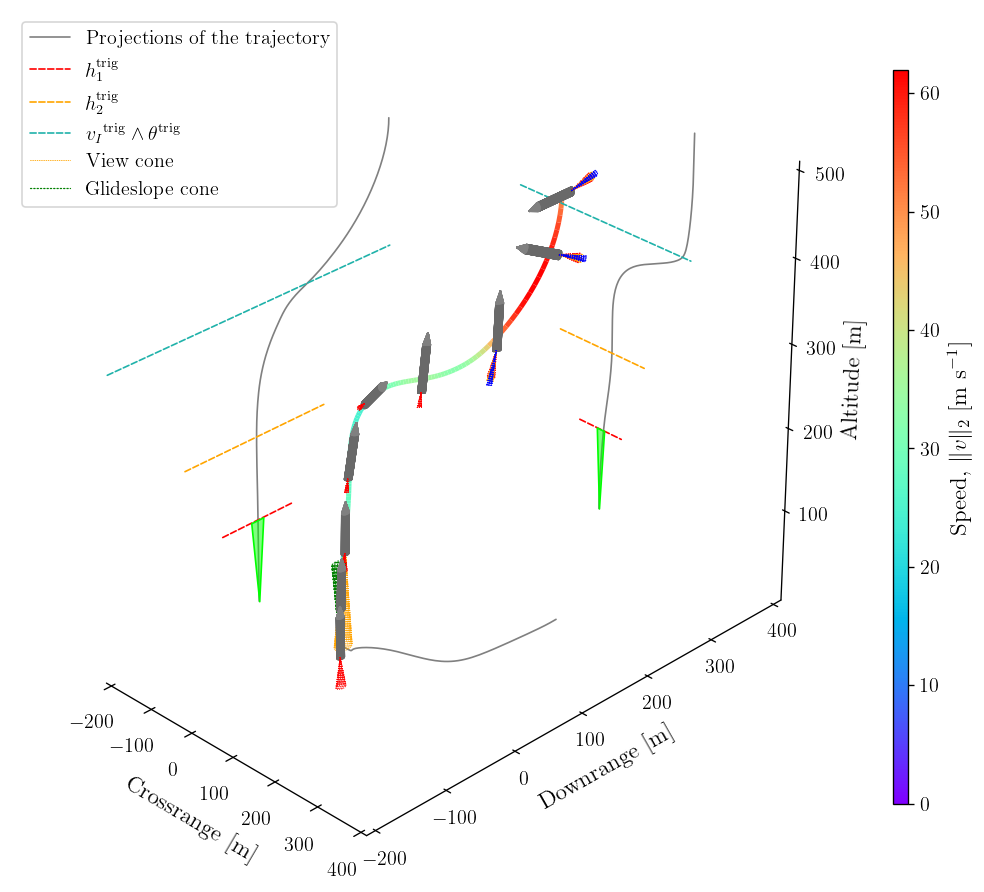

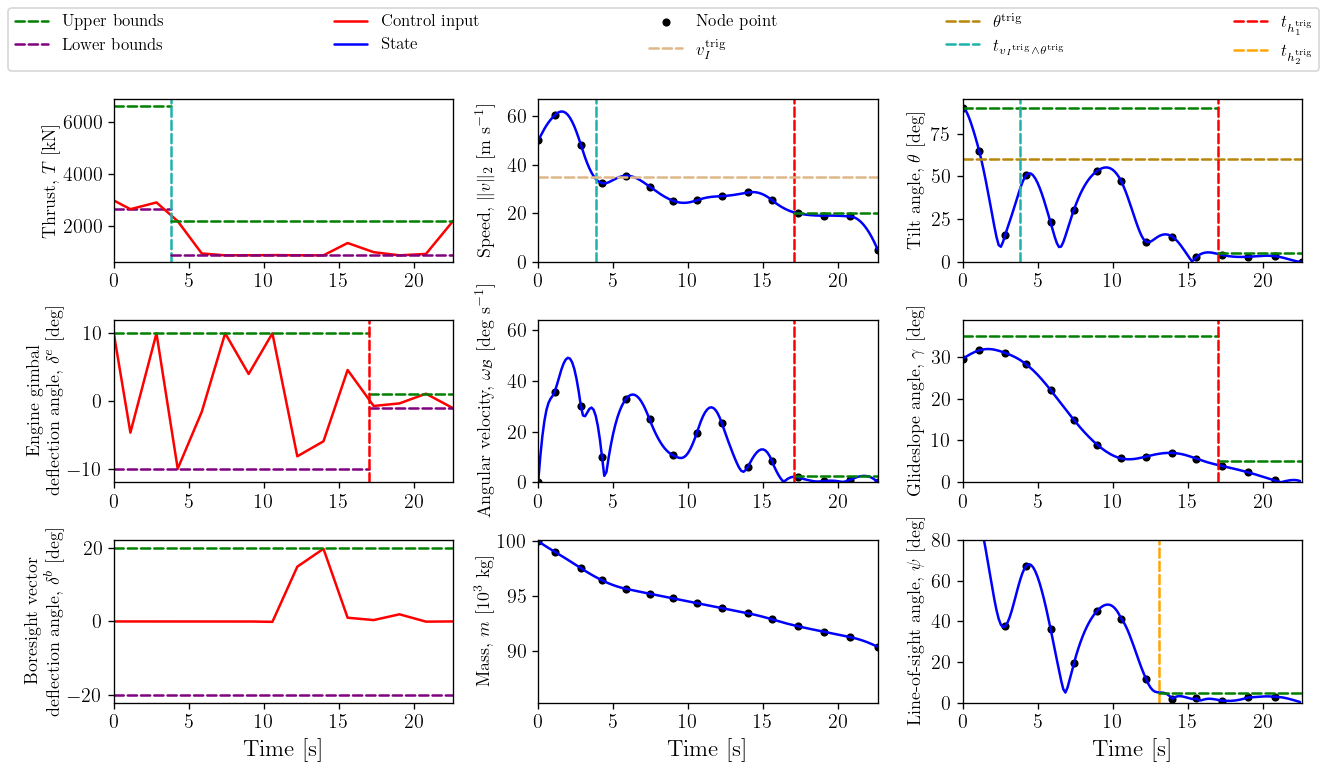

In [27]:
rl_plot(rl_results, rl_params)

In [28]:
# if rl_animations:
#     rl_plot(rl_results, rl_params, rl_anim=True)
#     make_gif('sim', duration = 5.0, name='rocket_landing')